In [1]:
import re
import datetime
import pathlib
import polars as pl # type: ignore
import matplotlib.pyplot as plt # type: ignore
from matplotlib.patches import Patch
import seaborn as sns # type: ignore
from upsetplot import UpSet, from_contents # type: ignore

In [2]:
VERSION = datetime.datetime.now().strftime("%y%m%d%H%M")
print(f"Execute Date: {VERSION}")

Execute Date: 2501281130


## Parameters for papermill

In [12]:
foldseek_result_tsv = pathlib.Path("../out/rice_down/rice_down_tmalign_result/foldseek_rice_down_9606_tmalign.tsv")
rice_uniprot_idmapping_tsv = pathlib.Path("../out/rice_down/202412_execute/rice_down_idmapping_all.tsv")
water_result_dir_path = "../out/rice_down/rice_down_tmalign_result/result_water_tmalign"
needle_result_dir_path = "../out/rice_down/rice_down_tmalign_result/result_needle_tmalign"
gene_list_tsv_path = "../Data/Data_HN5_genelist_rice_2402/HN5_genes_down_rice.tsv"
togoid_convert_tsv_path = "../out/rice_down/rice_down_tmalign_result/rice_down_tmalign_togoid_convert.tsv"
query_idmapping_tsv_path = "../Data/Data_uniprot/rice_down_idmapping_20241004.tsv"
target_idmapping_tsv_path = "../Data/Data_uniprot/rice_down_human_idmapping_20241004.tsv"
pan_homology_tsv_path = "../out/rice_down/202412_execute/rice_down_pan_homology_concat.tsv"

In [13]:
foldseek_result_df = pl.read_csv(
    foldseek_result_tsv,
    separator='\t'
)

foldseek_result = pl.read_csv(
    rice_uniprot_idmapping_tsv,
    separator='\t'
).join(
    foldseek_result_df,
    on="UniProt Accession",
    how="inner",
    coalesce=True
).drop(
    "taxlineage",
    "qaln",
    "taln",
    "lddtfull"
).sort(
    by=["From", "foldseek hit", "UniProt Accession"], # sort by From, foldseek hit, UniProt Accession, qcov, lddt
    descending=[False, False, False]
).with_columns( # add foldseek hit ID for upset plot
    pl.struct(
        [
            "From",
            "foldseek hit",
            "UniProt Accession"
        ]
    ).rank("dense").alias("hit ID")
).with_columns( # assign label for upset plot
    (pl.lit("foldseek-hit-") + pl.col("hit ID").cast(pl.Utf8)).alias("hit label")
).drop(
    "hit ID",
    "From_right"
).rename( # (from article) If Foldseek is used in TM-align mode (parameter --alignment-type 1), TM-align is used for the alignment stage after the prefilter step, where we replace the reported E-value column with TM-scores normalized by the query length.
    {
        "evalue" : "normalized TM-score"
    }
)


display(foldseek_result)

From,UniProt Accession,foldseek hit,normalized TM-score,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch,hit label
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,str
"""Os01g0137950""","""A0A0P0UXR3""","""K7EP59""",0.4195,0.632,12,20.5,0.205,37,1,166,204,164,313,432,180,0.814,0.347,0.6359,0.5736,0.2842,0.2842,3.333,9606,"""Homo sapiens""",99,"""foldseek-hit-1"""
"""Os01g0179600""","""B7FAP2""","""A0A0G2JMZ5""",0.5434,0.301,25,11.6,0.116,41,159,487,487,1,274,332,351,0.676,0.825,0.5456,0.4572,0.6525,0.6525,3.817,9606,"""Homo sapiens""",211,"""foldseek-hit-2"""
"""Os01g0179600""","""Q0JQ63""","""A0A0G2JMZ5""",0.5417,0.301,25,11.3,0.113,40,159,487,487,1,274,332,351,0.676,0.825,0.5464,0.4563,0.6501,0.6501,3.875,9606,"""Homo sapiens""",212,"""foldseek-hit-3"""
"""Os01g0179600""","""B7FAP2""","""A0A140T9Z0""",0.4948,0.692,43,10.4,0.104,53,25,487,487,241,635,693,509,0.951,0.57,0.4636,0.5876,0.4285,0.4285,4.812,9606,"""Homo sapiens""",296,"""foldseek-hit-4"""
"""Os01g0179600""","""Q0JQ63""","""A0A140T9Z0""",0.4949,0.692,44,9.5,0.095,49,25,487,487,241,635,693,514,0.951,0.57,0.4665,0.5874,0.4266,0.4266,4.579,9606,"""Homo sapiens""",295,"""foldseek-hit-5"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0610800""","""Q0ILZ7""","""Q96FX8""",0.5859,0.72,12,2.9,0.029,6,13,188,195,1,176,193,202,0.903,0.912,0.5907,0.6113,0.6166,0.6166,3.79,9606,"""Homo sapiens""",144,"""foldseek-hit-15497"""
"""Os12g0610800""","""Q0ILZ7""","""Q9BQJ4""",0.6392,0.795,20,4.2,0.042,9,2,193,195,1,181,181,214,0.985,1.0,0.5733,0.6495,0.6929,0.6929,3.69,9606,"""Homo sapiens""",150,"""foldseek-hit-15498"""
"""Os12g0610800""","""Q0ILZ7""","""Q9BY19""",0.5631,0.817,14,6.9,0.069,14,1,189,195,46,213,250,201,0.969,0.672,0.6106,0.6502,0.5221,0.5221,3.484,9606,"""Homo sapiens""",142,"""foldseek-hit-15499"""


&nbsp;


### Structural alignment identical match vs LDDT

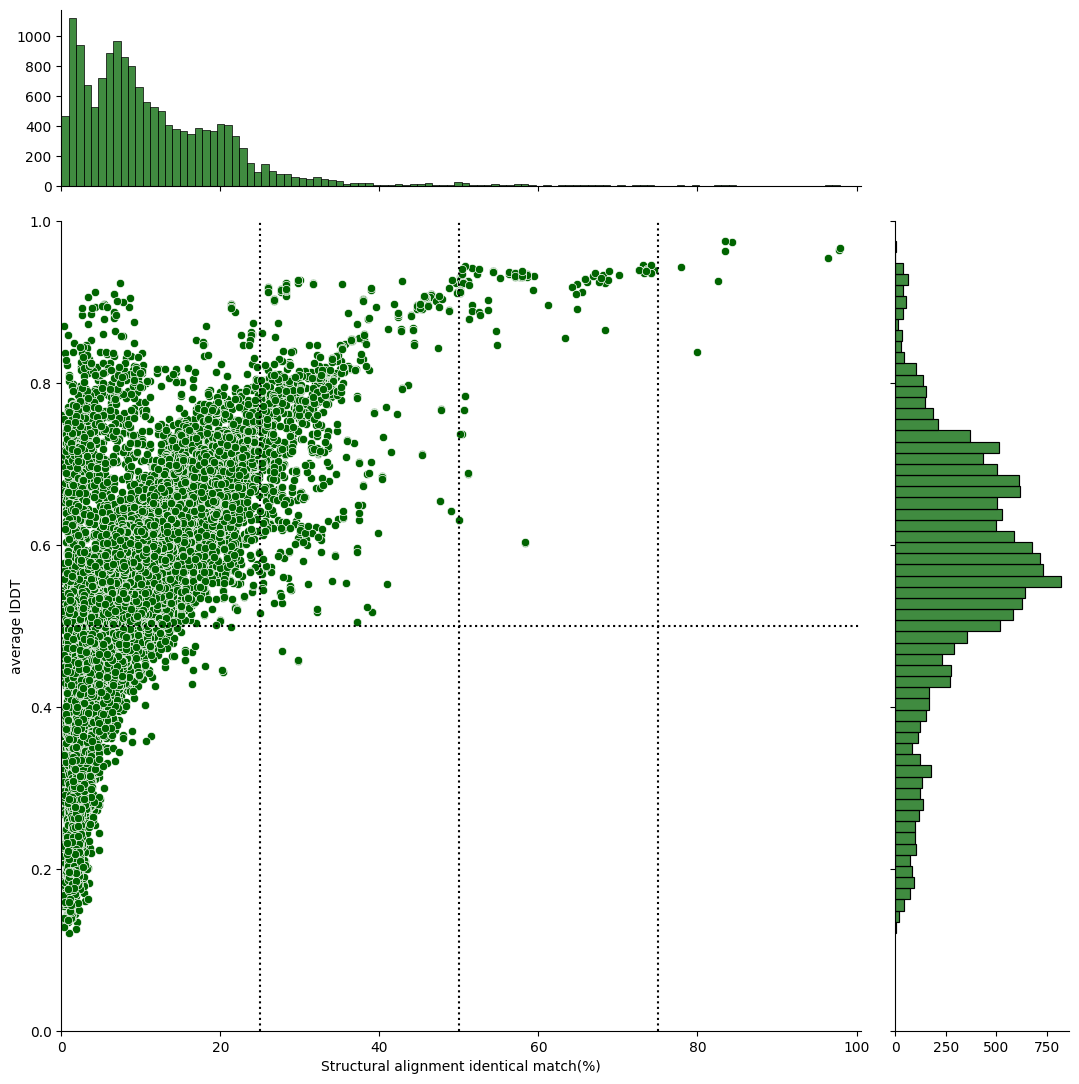

<Figure size 4000x4000 with 0 Axes>

In [14]:
foldseek_filter_viz = foldseek_result.to_pandas()
sns.jointplot(
    data=foldseek_filter_viz,
    x="pident", # structural alignment identical match from foldseek result
    y="lddt",
    color="darkgreen",
    height=11,
    ratio=4,
    marginal_ticks=True
)

plt.xlim(0,100.5)
plt.ylim(0,1)
plt.xlabel("Structural alignment identical match(%)")
plt.ylabel("average lDDT")
plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")
plt.figure(figsize=(8, 8), dpi=500)
plt.show()

&nbsp;

&nbsp;

&nbsp;

## Parse pairwise alignment result

In [15]:
def parse_needle_water_result(file_path: str):
    with open(file_path, "r", encoding="utf-8") as file:
        data = file.readlines()
        
    result = {
        "UniProt Accession": None,
        "foldseek hit": None,
        "Length": None,
        "Identity": None,
        "Identity_percent": None,
        "Similarity": None,
        "Similarity_percent": None,
        "Gaps": None,
        "Gaps_percent": None,
        "Score": None
    }
    
    for line in data:
        if line.startswith('# 1:'):
            result['UniProt Accession'] = line.split(':')[1].strip()
        elif line.startswith('# 2:'):
            result['foldseek hit'] = line.split(':')[1].strip()
        elif line.startswith('# Length:'):
            result['Length'] = int(line.split()[2])
        elif line.startswith('# Identity:'):
            result['Identity'] = line.split()[2]
            result['Identity_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Similarity:'):
            result['Similarity'] = line.split()[2]
            result['Similarity_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Gaps:'):
            result['Gaps'] = line.split()[2]
            result['Gaps_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Score:'):
            result['Score'] = float(line.split()[2])
            
    return result

In [16]:
water_result_dir = pathlib.Path(water_result_dir_path)
needle_result_dir = pathlib.Path(needle_result_dir_path)

# Initialize empty lists to store DataFrames
water_dfs = []
needle_dfs = []

# Collect all water results
for result_file in water_result_dir.glob("*_align.water"):
    parsed_data = parse_needle_water_result(result_file)
    water_dfs.append(pl.DataFrame([parsed_data]))

# Collect all needle results    
for result_file in needle_result_dir.glob("*_align.needle"):
    parsed_data = parse_needle_water_result(result_file)
    needle_dfs.append(pl.DataFrame([parsed_data]))

# Combine all results and sort only if there are results
water_result = (pl.concat(water_dfs, how='vertical')
                .sort(["UniProt Accession", "foldseek hit"]) 
                if water_dfs else pl.DataFrame())

needle_result = (pl.concat(needle_dfs, how='vertical')
                 .sort(["UniProt Accession", "foldseek hit"])
                 if needle_dfs else pl.DataFrame())

display(water_result)
display(needle_result)

UniProt Accession,foldseek hit,Length,Identity,Identity_percent,Similarity,Similarity_percent,Gaps,Gaps_percent,Score
str,str,i64,str,f64,str,f64,str,f64,f64
"""A0A0N7KD90""","""A0A024R6G4""",502,"""153/502""",30.5,"""246/502""",49.0,"""38/502""",7.6,545.0
"""A0A0N7KD90""","""A0A024RAC7""",457,"""124/457""",27.1,"""217/457""",47.5,"""47/457""",10.3,395.0
"""A0A0N7KD90""","""A0A087WUF8""",172,"""44/172""",25.6,"""68/172""",39.5,"""50/172""",29.1,103.0
"""A0A0N7KD90""","""A0A087X192""",244,"""65/244""",26.6,"""97/244""",39.8,"""57/244""",23.4,139.5
"""A0A0N7KD90""","""A0A087X2D4""",475,"""97/475""",20.4,"""159/475""",33.5,"""180/475""",37.9,213.0
…,…,…,…,…,…,…,…,…,…
"""V9G2Z0""","""Q8WUM4""",786,"""153/786""",19.5,"""263/786""",33.5,"""231/786""",29.4,93.0
"""V9G2Z0""","""Q92888""",856,"""162/856""",18.9,"""277/856""",32.4,"""263/856""",30.7,86.0
"""V9G2Z0""","""Q96PM5""",241,"""107/241""",44.4,"""138/241""",57.3,"""6/241""",2.5,597.0


UniProt Accession,foldseek hit,Length,Identity,Identity_percent,Similarity,Similarity_percent,Gaps,Gaps_percent,Score
str,str,i64,str,f64,str,f64,str,f64,f64
"""A0A0N7KD90""","""A0A024R6G4""",557,"""155/557""",27.8,"""250/557""",44.9,"""72/557""",12.9,531.0
"""A0A0N7KD90""","""A0A024RAC7""",606,"""137/606""",22.6,"""236/606""",38.9,"""142/606""",23.4,373.0
"""A0A0N7KD90""","""A0A087WUF8""",540,"""48/540""",8.9,"""73/540""",13.5,"""404/540""",74.8,97.0
"""A0A0N7KD90""","""A0A087X192""",527,"""65/527""",12.3,"""98/527""",18.6,"""336/527""",63.8,137.5
"""A0A0N7KD90""","""A0A087X2D4""",557,"""99/557""",17.8,"""162/557""",29.1,"""256/557""",46.0,205.5
…,…,…,…,…,…,…,…,…,…
"""V9G2Z0""","""Q8WUM4""",1414,"""189/1414""",13.4,"""319/1414""",22.6,"""724/1414""",51.2,54.5
"""V9G2Z0""","""Q92888""",1497,"""189/1497""",12.6,"""316/1497""",21.1,"""846/1497""",56.5,72.5
"""V9G2Z0""","""Q96PM5""",1247,"""112/1247""",9.0,"""145/1247""",11.6,"""997/1247""",80.0,590.0


In [17]:
alignment_result = water_result.join(
    needle_result,
    on=["UniProt Accession", "foldseek hit"],
    how="inner",
    coalesce=True,
    suffix="_needle"
).rename(
    {
        "Length": "Length_water",
        "Identity": "Identity_water",
        "Identity_percent": "Identity_percent_water",
        "Similarity": "Similarity_water",
        "Similarity_percent": "Similarity_percent_water",
        "Gaps": "Gaps_water",
        "Gaps_percent": "Gaps_percent_water",
        "Score": "Score_water"
    }
).select(
    [
        "UniProt Accession",
        "foldseek hit",
        "Length_water",
        "Length_needle",
        "Identity_water",
        "Identity_needle",
        "Identity_percent_water",
        "Identity_percent_needle",
        "Similarity_percent_water",
        "Similarity_percent_needle",
        "Gaps_water",
        "Gaps_percent_water",
        "Gaps_needle",
        "Gaps_percent_needle",
        "Score_water",
        "Score_needle"
    ]
).sort(
    by=["UniProt Accession", "foldseek hit"],
    descending=[False, False]
)

display(alignment_result)

UniProt Accession,foldseek hit,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_percent_water,Gaps_needle,Gaps_percent_needle,Score_water,Score_needle
str,str,i64,i64,str,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64
"""A0A0N7KD90""","""A0A024R6G4""",502,557,"""153/502""","""155/557""",30.5,27.8,49.0,44.9,"""38/502""",7.6,"""72/557""",12.9,545.0,531.0
"""A0A0N7KD90""","""A0A024RAC7""",457,606,"""124/457""","""137/606""",27.1,22.6,47.5,38.9,"""47/457""",10.3,"""142/606""",23.4,395.0,373.0
"""A0A0N7KD90""","""A0A087WUF8""",172,540,"""44/172""","""48/540""",25.6,8.9,39.5,13.5,"""50/172""",29.1,"""404/540""",74.8,103.0,97.0
"""A0A0N7KD90""","""A0A087X192""",244,527,"""65/244""","""65/527""",26.6,12.3,39.8,18.6,"""57/244""",23.4,"""336/527""",63.8,139.5,137.5
"""A0A0N7KD90""","""A0A087X2D4""",475,557,"""97/475""","""99/557""",20.4,17.8,33.5,29.1,"""180/475""",37.9,"""256/557""",46.0,213.0,205.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""V9G2Z0""","""Q8WUM4""",786,1414,"""153/786""","""189/1414""",19.5,13.4,33.5,22.6,"""231/786""",29.4,"""724/1414""",51.2,93.0,54.5
"""V9G2Z0""","""Q92888""",856,1497,"""162/856""","""189/1497""",18.9,12.6,32.4,21.1,"""263/856""",30.7,"""846/1497""",56.5,86.0,72.5
"""V9G2Z0""","""Q96PM5""",241,1247,"""107/241""","""112/1247""",44.4,9.0,57.3,11.6,"""6/241""",2.5,"""997/1247""",80.0,597.0,590.0


&nbsp;


&nbsp;

## Integrate foldseek result and pairwise alignment result

- This time, **exclude the ones that are null in pairwise alignment result, which means the current UniProt entry is obsolete**

In [18]:
join_foldseek = foldseek_result.join(
    alignment_result,
    on=["UniProt Accession", "foldseek hit"],
    how="left",
    coalesce=True
).filter( # filter out null alignment result (this means current UniProt entry is obsolete)
    pl.col("Length_water").is_not_null() & 
    pl.col("Length_needle").is_not_null()
).sort(
    by=["From", "foldseek hit", "UniProt Accession"],
    descending=[False, False, False]
)


print(join_foldseek.group_by(["From"], maintain_order=True).n_unique())
display(join_foldseek)

shape: (207, 41)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ From      ┆ UniProt   ┆ foldseek  ┆ normalize ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ Accession ┆ hit       ┆ d         ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ ---       ┆ ---       ┆ TM-score  ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆ u32       ┆ u32       ┆ ---       ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32      │
│           ┆           ┆           ┆ u32       ┆   ┆           ┆ u32       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Os01g0179 ┆ 2         ┆ 60        ┆ 106       ┆ … ┆ 32        ┆ 32        ┆ 29        ┆ 39       │
│ 600       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0192 ┆ 1         ┆ 11        ┆ 11        ┆ … ┆ 10        ┆ 10      

From,UniProt Accession,foldseek hit,normalized TM-score,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch,hit label,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_percent_water,Gaps_needle,Gaps_percent_needle,Score_water,Score_needle
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64
"""Os01g0179600""","""B7FAP2""","""A0A0G2JMZ5""",0.5434,0.301,25,11.6,0.116,41,159,487,487,1,274,332,351,0.676,0.825,0.5456,0.4572,0.6525,0.6525,3.817,9606,"""Homo sapiens""",211,"""foldseek-hit-2""",219,585,"""55/219""","""62/585""",25.1,10.6,42.0,19.3,"""24/219""",11.0,"""351/585""",60.0,138.5,112.0
"""Os01g0179600""","""Q0JQ63""","""A0A0G2JMZ5""",0.5417,0.301,25,11.3,0.113,40,159,487,487,1,274,332,351,0.676,0.825,0.5464,0.4563,0.6501,0.6501,3.875,9606,"""Homo sapiens""",212,"""foldseek-hit-3""",219,585,"""55/219""","""62/585""",25.1,10.6,42.0,19.3,"""24/219""",11.0,"""351/585""",60.0,138.5,112.0
"""Os01g0179600""","""B7FAP2""","""A0A140T9Z0""",0.4948,0.692,43,10.4,0.104,53,25,487,487,241,635,693,509,0.951,0.57,0.4636,0.5876,0.4285,0.4285,4.812,9606,"""Homo sapiens""",296,"""foldseek-hit-4""",320,775,"""74/320""","""122/775""",23.1,15.7,33.4,25.7,"""116/320""",36.2,"""370/775""",47.7,126.0,89.5
"""Os01g0179600""","""Q0JQ63""","""A0A140T9Z0""",0.4949,0.692,44,9.5,0.095,49,25,487,487,241,635,693,514,0.951,0.57,0.4665,0.5874,0.4266,0.4266,4.579,9606,"""Homo sapiens""",295,"""foldseek-hit-5""",320,775,"""74/320""","""122/775""",23.1,15.7,33.4,25.7,"""116/320""",36.2,"""370/775""",47.7,126.0,89.5
"""Os01g0179600""","""B7FAP2""","""A0A804HJ67""",0.5912,0.106,13,18.0,0.18,38,230,437,487,1,173,173,210,0.427,1.0,0.5135,0.3304,0.8801,0.8801,2.397,9606,"""Homo sapiens""",133,"""foldseek-hit-8""",129,492,"""37/129""","""50/492""",28.7,10.2,45.0,16.1,"""8/129""",6.2,"""324/492""",65.9,134.0,118.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0610800""","""Q0ILZ7""","""Q96FX8""",0.5859,0.72,12,2.9,0.029,6,13,188,195,1,176,193,202,0.903,0.912,0.5907,0.6113,0.6166,0.6166,3.79,9606,"""Homo sapiens""",144,"""foldseek-hit-15497""",54,361,"""15/54""","""12/361""",27.8,3.3,42.6,4.2,"""17/54""",31.5,"""334/361""",92.5,32.5,8.0
"""Os12g0610800""","""Q0ILZ7""","""Q9BQJ4""",0.6392,0.795,20,4.2,0.042,9,2,193,195,1,181,181,214,0.985,1.0,0.5733,0.6495,0.6929,0.6929,3.69,9606,"""Homo sapiens""",150,"""foldseek-hit-15498""",69,332,"""16/69""","""13/332""",23.2,3.9,40.6,6.3,"""10/69""",14.5,"""288/332""",86.7,31.5,12.5
"""Os12g0610800""","""Q0ILZ7""","""Q9BY19""",0.5631,0.817,14,6.9,0.069,14,1,189,195,46,213,250,201,0.969,0.672,0.6106,0.6502,0.5221,0.5221,3.484,9606,"""Homo sapiens""",142,"""foldseek-hit-15499""",47,312,"""12/47""","""32/312""",25.5,10.3,44.7,19.6,"""13/47""",27.7,"""179/312""",57.4,34.5,14.0


&nbsp;

&nbsp;

&nbsp;

## Create Scatter Plot for all hits

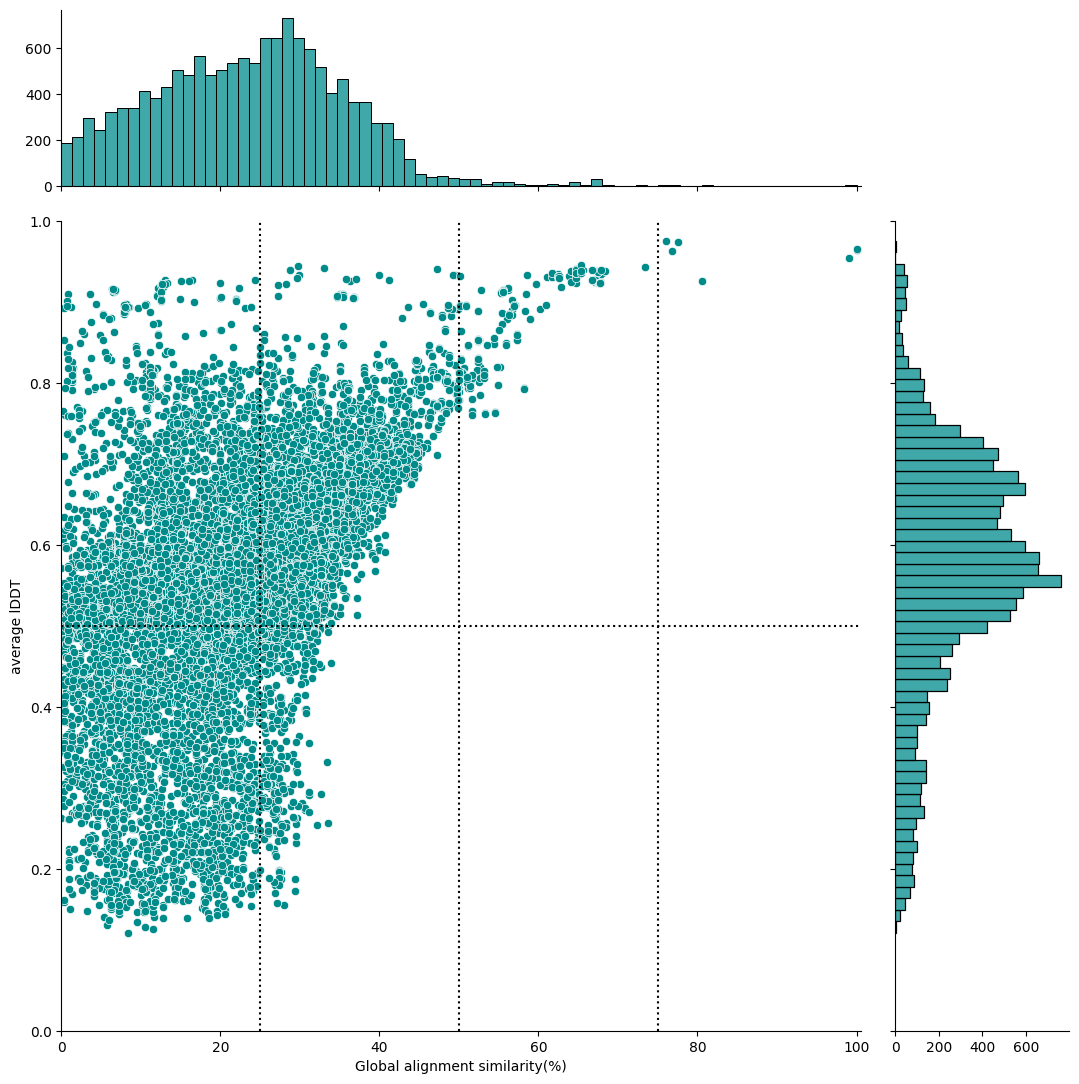

<Figure size 1500x1500 with 0 Axes>

In [19]:
foldseek_filter_viz2 = join_foldseek.to_pandas()

sns.jointplot(
    data=foldseek_filter_viz2,
    x="Similarity_percent_needle",
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

plt.xlim(0,100.5)
plt.ylim(0,1)
plt.xlabel("Global alignment similarity(%)")
plt.ylabel("average lDDT")
plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")
plt.figure(figsize=(5, 5), dpi=300)
plt.show()

&nbsp;

&nbsp;


## (Experimental) figure that change y-axis to strucutural alignment target coverage

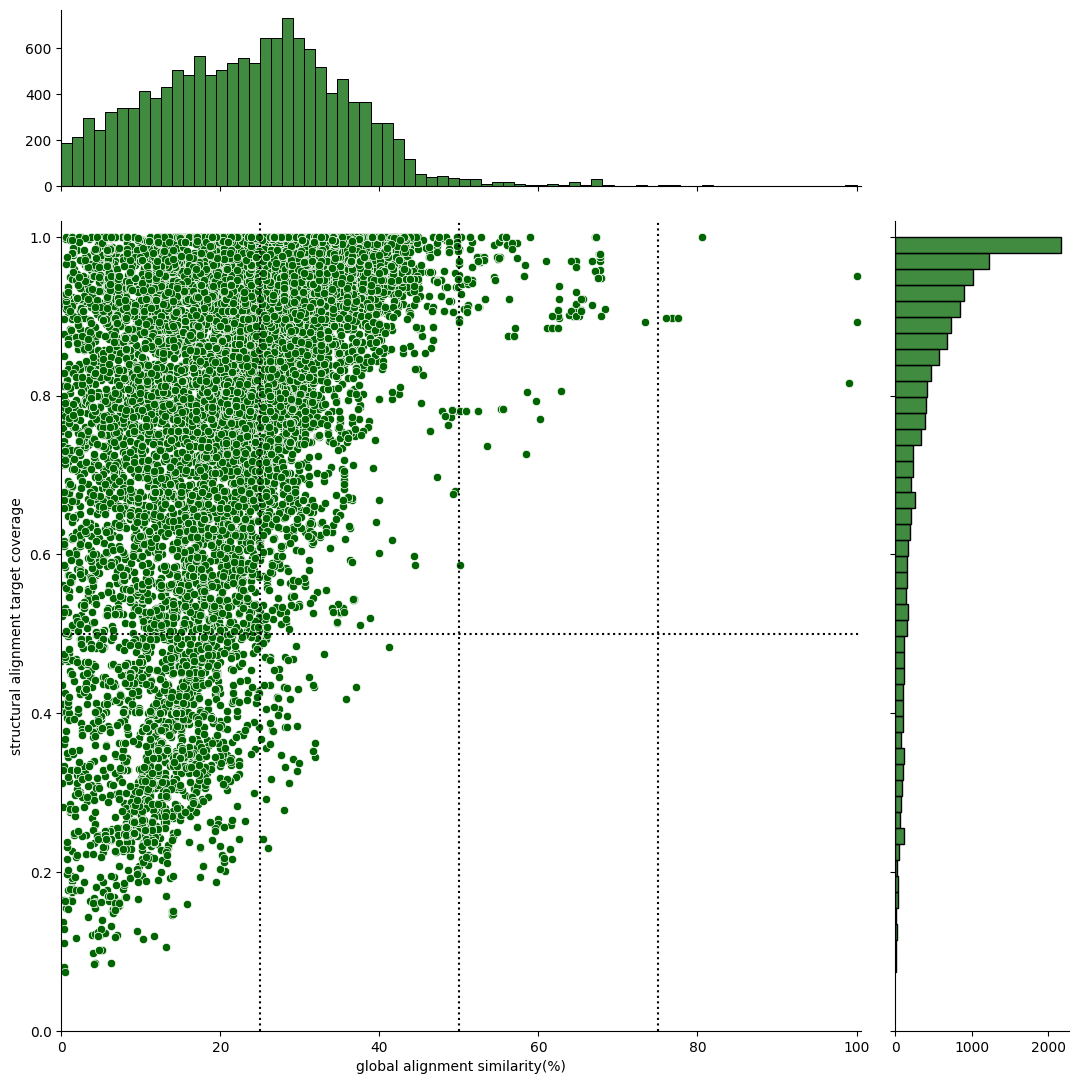

<Figure size 5000x5000 with 0 Axes>

In [20]:
sns.jointplot(
    data=foldseek_filter_viz2,
    x="Similarity_percent_needle",
    y="tcov",
    color="darkgreen",
    height=11,
    ratio=4,
    marginal_ticks=True
)

plt.xlim(0,100.5)
plt.ylim(0,1.02)
plt.xlabel("global alignment similarity(%)")
plt.ylabel("structural alignment target coverage")
plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")
plt.figure(figsize=(10, 10), dpi=500)
plt.show()

&nbsp;

&nbsp;

&nbsp;


## Counting foldseek hits

- 遺伝子レベルで､foldseekでヒットがないものをカウントする

In [21]:
# 遺伝子レベルでのヒットカウントを算出
all_gene_list = pl.read_csv(
    gene_list_tsv_path,
    separator='\t'
).select(
    "From"
).unique()

hit_count = all_gene_list.join(
    join_foldseek,
    on="From",
    how="left",
    coalesce=True
).group_by("From", maintain_order=True).agg(
    (pl.col("foldseek hit").count().alias("target hit count (gene level vs uniprot accession)")),
    (pl.col("foldseek hit").is_null().all().alias("foldseek no hit"))
).sort(
    ["target hit count (gene level vs uniprot accession)"], descending=True
)

display(hit_count)
    
# hit_count.write_csv(
#     "../out/rice_down/foldseek_rice_down_hit_count.tsv",
#     separator='\t'
# )

no_hit_genes_list = hit_count.filter(
    pl.col("foldseek no hit") == True
)

idmapping_list = pl.read_csv(
    rice_uniprot_idmapping_tsv,
    separator='\t'
)
  
no_hit_idmapping_list = no_hit_genes_list.join(
    idmapping_list,
    on="From",
    how="left"
).sort(
    by=["From"],
    descending=[False]
)

print(no_hit_idmapping_list.group_by(["From"], maintain_order=True).n_unique())
display(no_hit_idmapping_list)

From,target hit count (gene level vs uniprot accession),foldseek no hit
str,u32,bool
"""Os03g0833100""",314,false
"""Os04g0453200""",313,false
"""Os12g0512100""",293,false
"""Os03g0760200""",293,false
"""Os01g0591300""",272,false
…,…,…
"""Os09g0325000""",0,true
"""Os09g0110300""",0,true
"""Os03g0400200""",0,true


shape: (163, 4)
┌──────────────┬─────────────────────────────────┬─────────────────┬───────────────────┐
│ From         ┆ target hit count (gene level v… ┆ foldseek no hit ┆ UniProt Accession │
│ ---          ┆ ---                             ┆ ---             ┆ ---               │
│ str          ┆ u32                             ┆ u32             ┆ u32               │
╞══════════════╪═════════════════════════════════╪═════════════════╪═══════════════════╡
│ Os01g0105300 ┆ 1                               ┆ 1               ┆ 1                 │
│ Os01g0136300 ┆ 1                               ┆ 1               ┆ 2                 │
│ Os01g0137950 ┆ 1                               ┆ 1               ┆ 1                 │
│ Os01g0216000 ┆ 1                               ┆ 1               ┆ 2                 │
│ Os01g0220700 ┆ 1                               ┆ 1               ┆ 1                 │
│ …            ┆ …                               ┆ …               ┆ …                 │
│ Os1

From,target hit count (gene level vs uniprot accession),foldseek no hit,UniProt Accession
str,u32,bool,str
"""Os01g0105300""",0,true,"""A0A0P0UWX1"""
"""Os01g0136300""",0,true,"""A0A8J8YJH9"""
"""Os01g0136300""",0,true,"""Q5ZC68"""
"""Os01g0137950""",0,true,"""A0A0P0UXR3"""
"""Os01g0216000""",0,true,"""Q0JPL7"""
…,…,…,…
"""Os12g0601800""",0,true,"""A0A0N7KUB6"""
"""Os12g0630100""",0,true,"""Q0ILR1"""
"""Os12g0630100""",0,true,"""Q2QLS8"""


&nbsp;

&nbsp;

## Filtering Condition1

- query coverage が 0.5以上, target coverage が 0.5以上のものを選抜する
- (これまでのcondition3の処理を先に行う)

In [22]:
condition1 = join_foldseek.filter(
        (pl.col("qcov") >= 0.5) &
        (pl.col("tcov") >= 0.5)
    ).sort(
        by=["From", "foldseek hit", "UniProt Accession"], # sort by From, foldseek hit, UniProt Accession
        descending=[False, False, False]
    )

condition1_rm = condition1.filter(
        (pl.col("qcov") < 0.5) |
        (pl.col("tcov") < 0.5)
    )

print(condition1.group_by(["From"], maintain_order=True).n_unique())
pl.Config.set_tbl_rows(10)
display(condition1)

shape: (199, 41)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ From      ┆ UniProt   ┆ foldseek  ┆ normalize ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ Accession ┆ hit       ┆ d         ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ ---       ┆ ---       ┆ TM-score  ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆ u32       ┆ u32       ┆ ---       ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32      │
│           ┆           ┆           ┆ u32       ┆   ┆           ┆ u32       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Os01g0179 ┆ 2         ┆ 56        ┆ 98        ┆ … ┆ 28        ┆ 28        ┆ 26        ┆ 36       │
│ 600       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0192 ┆ 1         ┆ 11        ┆ 11        ┆ … ┆ 10        ┆ 10      

From,UniProt Accession,foldseek hit,normalized TM-score,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch,hit label,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_percent_water,Gaps_needle,Gaps_percent_needle,Score_water,Score_needle
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64
"""Os01g0179600""","""B7FAP2""","""A0A0G2JMZ5""",0.5434,0.301,25,11.6,0.116,41,159,487,487,1,274,332,351,0.676,0.825,0.5456,0.4572,0.6525,0.6525,3.817,9606,"""Homo sapiens""",211,"""foldseek-hit-2""",219,585,"""55/219""","""62/585""",25.1,10.6,42.0,19.3,"""24/219""",11.0,"""351/585""",60.0,138.5,112.0
"""Os01g0179600""","""Q0JQ63""","""A0A0G2JMZ5""",0.5417,0.301,25,11.3,0.113,40,159,487,487,1,274,332,351,0.676,0.825,0.5464,0.4563,0.6501,0.6501,3.875,9606,"""Homo sapiens""",212,"""foldseek-hit-3""",219,585,"""55/219""","""62/585""",25.1,10.6,42.0,19.3,"""24/219""",11.0,"""351/585""",60.0,138.5,112.0
"""Os01g0179600""","""B7FAP2""","""A0A140T9Z0""",0.4948,0.692,43,10.4,0.104,53,25,487,487,241,635,693,509,0.951,0.57,0.4636,0.5876,0.4285,0.4285,4.812,9606,"""Homo sapiens""",296,"""foldseek-hit-4""",320,775,"""74/320""","""122/775""",23.1,15.7,33.4,25.7,"""116/320""",36.2,"""370/775""",47.7,126.0,89.5
"""Os01g0179600""","""Q0JQ63""","""A0A140T9Z0""",0.4949,0.692,44,9.5,0.095,49,25,487,487,241,635,693,514,0.951,0.57,0.4665,0.5874,0.4266,0.4266,4.579,9606,"""Homo sapiens""",295,"""foldseek-hit-5""",320,775,"""74/320""","""122/775""",23.1,15.7,33.4,25.7,"""116/320""",36.2,"""370/775""",47.7,126.0,89.5
"""Os01g0179600""","""B7FAP2""","""A3KME6""",0.6643,0.912,41,11.3,0.113,61,1,487,487,8,467,531,539,1.0,0.866,0.5605,0.7075,0.6542,0.6542,4.297,9606,"""Homo sapiens""",347,"""foldseek-hit-10""",430,657,"""90/430""","""106/657""",20.9,16.1,34.7,26.2,"""120/430""",27.9,"""296/657""",45.1,169.0,154.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0610800""","""Q0ILZ7""","""Q96FX8""",0.5859,0.72,12,2.9,0.029,6,13,188,195,1,176,193,202,0.903,0.912,0.5907,0.6113,0.6166,0.6166,3.79,9606,"""Homo sapiens""",144,"""foldseek-hit-15497""",54,361,"""15/54""","""12/361""",27.8,3.3,42.6,4.2,"""17/54""",31.5,"""334/361""",92.5,32.5,8.0
"""Os12g0610800""","""Q0ILZ7""","""Q9BQJ4""",0.6392,0.795,20,4.2,0.042,9,2,193,195,1,181,181,214,0.985,1.0,0.5733,0.6495,0.6929,0.6929,3.69,9606,"""Homo sapiens""",150,"""foldseek-hit-15498""",69,332,"""16/69""","""13/332""",23.2,3.9,40.6,6.3,"""10/69""",14.5,"""288/332""",86.7,31.5,12.5
"""Os12g0610800""","""Q0ILZ7""","""Q9BY19""",0.5631,0.817,14,6.9,0.069,14,1,189,195,46,213,250,201,0.969,0.672,0.6106,0.6502,0.5221,0.5221,3.484,9606,"""Homo sapiens""",142,"""foldseek-hit-15499""",47,312,"""12/47""","""32/312""",25.5,10.3,44.7,19.6,"""13/47""",27.7,"""179/312""",57.4,34.5,14.0


&nbsp;

&nbsp;


## Filtering Condition2

- 同じ遺伝子由来のUniProt IDに対して､同じtargetのヒットがある場合､qcovが最も高いものを選抜し，qcovが同じ場合はlddtが最も高いものを選抜する
- **本研究では，イネの遺伝子が異なっていても，同じfoldseek hitがある状態は残していることに注意**

In [23]:
condition2 = condition1.sort(
    by=["qcov", "lddt"],
    descending=[True, True]
).group_by(
    ["From", "foldseek hit"],
    maintain_order=True
).agg(
    pl.all().first()
).sort(
    by=["From", "foldseek hit", "UniProt Accession"],
    descending=[False, False, False]
)

# condition2_checked = condition2.filter(
#     pl.col("foldseek hit") == "X6R9L0"
# )

# display(condition2_checked)
display(condition2)

From,foldseek hit,UniProt Accession,normalized TM-score,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,mismatch,hit label,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_percent_water,Gaps_needle,Gaps_percent_needle,Score_water,Score_needle
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64
"""Os01g0179600""","""A0A0G2JMZ5""","""Q0JQ63""",0.5417,0.301,25,11.3,0.113,40,159,487,487,1,274,332,351,0.676,0.825,0.5464,0.4563,0.6501,0.6501,3.875,9606,"""Homo sapiens""",212,"""foldseek-hit-3""",219,585,"""55/219""","""62/585""",25.1,10.6,42.0,19.3,"""24/219""",11.0,"""351/585""",60.0,138.5,112.0
"""Os01g0179600""","""A0A140T9Z0""","""Q0JQ63""",0.4949,0.692,44,9.5,0.095,49,25,487,487,241,635,693,514,0.951,0.57,0.4665,0.5874,0.4266,0.4266,4.579,9606,"""Homo sapiens""",295,"""foldseek-hit-5""",320,775,"""74/320""","""122/775""",23.1,15.7,33.4,25.7,"""116/320""",36.2,"""370/775""",47.7,126.0,89.5
"""Os01g0179600""","""A3KME6""","""B7FAP2""",0.6643,0.912,41,11.3,0.113,61,1,487,487,8,467,531,539,1.0,0.866,0.5605,0.7075,0.6542,0.6542,4.297,9606,"""Homo sapiens""",347,"""foldseek-hit-10""",430,657,"""90/430""","""106/657""",20.9,16.1,34.7,26.2,"""120/430""",27.9,"""296/657""",45.1,169.0,154.0
"""Os01g0179600""","""A7E1U4""","""B7FAP2""",0.4744,0.164,39,6.8,0.068,29,1,377,487,10,289,289,426,0.774,0.969,0.4308,0.3846,0.6043,0.6043,4.846,9606,"""Homo sapiens""",202,"""foldseek-hit-12""",45,723,"""14/45""","""10/723""",31.1,1.4,44.4,3.2,"""6/45""",13.3,"""670/723""",92.7,35.0,15.0
"""Os01g0179600""","""A7E1U5""","""Q0JQ63""",0.4634,0.15,41,5.6,0.056,29,1,461,487,10,287,289,512,0.947,0.962,0.432,0.3758,0.5895,0.5895,4.899,9606,"""Homo sapiens""",198,"""foldseek-hit-14""",45,723,"""14/45""","""10/723""",31.1,1.4,44.4,3.2,"""6/45""",13.3,"""670/723""",92.7,35.0,15.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0610800""","""Q96FX8""","""Q0ILZ7""",0.5859,0.72,12,2.9,0.029,6,13,188,195,1,176,193,202,0.903,0.912,0.5907,0.6113,0.6166,0.6166,3.79,9606,"""Homo sapiens""",144,"""foldseek-hit-15497""",54,361,"""15/54""","""12/361""",27.8,3.3,42.6,4.2,"""17/54""",31.5,"""334/361""",92.5,32.5,8.0
"""Os12g0610800""","""Q9BQJ4""","""Q0ILZ7""",0.6392,0.795,20,4.2,0.042,9,2,193,195,1,181,181,214,0.985,1.0,0.5733,0.6495,0.6929,0.6929,3.69,9606,"""Homo sapiens""",150,"""foldseek-hit-15498""",69,332,"""16/69""","""13/332""",23.2,3.9,40.6,6.3,"""10/69""",14.5,"""288/332""",86.7,31.5,12.5
"""Os12g0610800""","""Q9BY19""","""Q0ILZ7""",0.5631,0.817,14,6.9,0.069,14,1,189,195,46,213,250,201,0.969,0.672,0.6106,0.6502,0.5221,0.5221,3.484,9606,"""Homo sapiens""",142,"""foldseek-hit-15499""",47,312,"""12/47""","""32/312""",25.5,10.3,44.7,19.6,"""13/47""",27.7,"""179/312""",57.4,34.5,14.0


&nbsp;

&nbsp;


## Filtering Condition3

- TogoIDでEnsembl gene idに変換できるヒットを選抜する
- おそらく1つのUniProt IDに対して，複数のgene IDが対応している可能性がある

In [24]:
togoid_convert = pl.read_csv(
    togoid_convert_tsv_path,
    separator='\t'
).rename(
    {
        "uniprot_id" : "foldseek hit"
    }
).filter(
    pl.col("ensembl_gene_id").is_not_null()
).sort(
    by=["foldseek hit"],
    descending=[False]
)

display(togoid_convert)

foldseek hit,ensembl_protein_id,ensembl_transcript_id,ensembl_gene_id,hgnc_id,hgnc_symbol_id
str,str,str,str,i64,str
"""A0A024QZP7""","""ENSP00000397973""","""ENST00000448257""","""ENSG00000170312""",1722,"""CDK1"""
"""A0A024QZW4""","""ENSP00000498054""","""ENST00000648987""","""ENSG00000124786""",21601,"""SLC35B3"""
"""A0A024QZW4""","""ENSP00000518269""","""ENST00000710437""","""ENSG00000124786""",21601,"""SLC35B3"""
"""A0A024R3M2""","""ENSP00000489896""","""ENST00000638157""","""ENSG00000023171""",29214,"""GRAMD1B"""
"""A0A024R5G9""","""ENSP00000435822""","""ENST00000526010""","""ENSG00000174080""",2531,"""CTSF"""
…,…,…,…,…,…
"""X6RIU2""","""ENSP00000409912""","""ENST00000442513""","""ENSG00000163075""",33720,"""CFAP221"""
"""X6RLA8""","""ENSP00000416709""","""ENST00000437579""","""ENSG00000107954""",7761,"""NEURL1"""
"""X6RLX0""","""ENSP00000442739""","""ENST00000546231""","""ENSG00000082805""",17072,"""ERC1"""


In [26]:
condition3 = condition2.join(
    togoid_convert,
    on="foldseek hit",
    how="left",
    coalesce=True
).drop(
    [
        "ensembl_transcript_id",
        "hgnc_id"
    ]
).filter(
    pl.col("ensembl_gene_id").is_not_null()
).select(
    [
        "hit label",
        "From",
        "UniProt Accession",
        "foldseek hit",
        "ensembl_protein_id",
        "ensembl_gene_id",
        "hgnc_symbol_id",
        "normalized TM-score",
        "prob",
        "gapopen",
        "pident",
        "fident",
        "nident",
        "qstart",
        "qend",
        "qlen",
        "tstart",
        "tend",
        "tlen",
        "alnlen",
        "mismatch",
        "qcov",
        "tcov",
        "rmsd",
        "lddt",
        "qtmscore",
        "ttmscore",
        "alntmscore",
        "taxid",
        "taxname",
        "Length_water",
        "Length_needle",
        "Identity_water",
        "Identity_percent_water",
        "Identity_percent_needle",
        "Similarity_percent_water",
        "Similarity_percent_needle",
        "Gaps_water",
        "Gaps_percent_water",
        "Gaps_needle",
        "Gaps_percent_needle",
        "Score_water",
        "Score_needle"
    ]
).sort(
    by=["From", "foldseek hit", "UniProt Accession"], # sort by From, foldseek hit, UniProt Accession (change order)
    descending=[False, False, False]
)

print(condition3.group_by(["From", "UniProt Accession", "foldseek hit"], maintain_order=True).n_unique())
display(condition3)


shape: (5_139, 43)
┌────────────┬────────────┬────────────┬───────┬───┬───────────┬───────────┬───────────┬───────────┐
│ From       ┆ UniProt    ┆ foldseek   ┆ hit   ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_nee │
│ ---        ┆ Accession  ┆ hit        ┆ label ┆   ┆ le        ┆ ent_needl ┆ er        ┆ dle       │
│ str        ┆ ---        ┆ ---        ┆ ---   ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---       │
│            ┆ str        ┆ str        ┆ u32   ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32       │
│            ┆            ┆            ┆       ┆   ┆           ┆ u32       ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Os01g01796 ┆ Q0JQ63     ┆ A0A0G2JMZ5 ┆ 1     ┆ … ┆ 1         ┆ 1         ┆ 1         ┆ 1         │
│ 00         ┆            ┆            ┆       ┆   ┆           ┆           ┆           ┆           │
│ Os01g01796 ┆ Q0JQ63     ┆ A0A140T9Z0 ┆ 1     ┆ … ┆ 1         ┆ 1      

hit label,From,UniProt Accession,foldseek hit,ensembl_protein_id,ensembl_gene_id,hgnc_symbol_id,normalized TM-score,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,mismatch,qcov,tcov,rmsd,lddt,qtmscore,ttmscore,alntmscore,taxid,taxname,Length_water,Length_needle,Identity_water,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_percent_water,Gaps_needle,Gaps_percent_needle,Score_water,Score_needle
str,str,str,str,str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64
"""foldseek-hit-3""","""Os01g0179600""","""Q0JQ63""","""A0A0G2JMZ5""","""ENSP00000480287""","""ENSG00000277132""","""UGT2B15""",0.5417,0.301,25,11.3,0.113,40,159,487,487,1,274,332,351,212,0.676,0.825,3.875,0.5464,0.4563,0.6501,0.6501,9606,"""Homo sapiens""",219,585,"""55/219""",25.1,10.6,42.0,19.3,"""24/219""",11.0,"""351/585""",60.0,138.5,112.0
"""foldseek-hit-5""","""Os01g0179600""","""Q0JQ63""","""A0A140T9Z0""","""ENSP00000425497""","""ENSG00000173610""","""UGT2A1""",0.4949,0.692,44,9.5,0.095,49,25,487,487,241,635,693,514,295,0.951,0.57,4.579,0.4665,0.5874,0.4266,0.4266,9606,"""Homo sapiens""",320,775,"""74/320""",23.1,15.7,33.4,25.7,"""116/320""",36.2,"""370/775""",47.7,126.0,89.5
"""foldseek-hit-31""","""Os01g0179600""","""B7FAP2""","""B7Z8Q8""","""ENSP00000427079""","""ENSG00000145626""","""UGT3A1""",0.684,0.872,41,10.8,0.108,55,1,457,487,3,436,436,506,330,0.938,0.995,4.479,0.541,0.6665,0.7367,0.7367,9606,"""Homo sapiens""",213,580,"""57/213""",26.8,16.2,40.8,28.8,"""53/213""",24.9,"""237/580""",40.9,151.0,132.5
"""foldseek-hit-54""","""Os01g0179600""","""Q0JQ63""","""O60656""","""ENSP00000346768""","""ENSG00000241119""","""UGT1A9""",0.6624,0.912,45,11.9,0.119,64,1,487,487,10,466,530,534,346,1.0,0.862,4.562,0.5659,0.7047,0.6527,0.6527,9606,"""Homo sapiens""",177,643,"""46/177""",26.0,15.9,43.5,27.7,"""30/177""",16.9,"""269/643""",41.8,145.5,121.0
"""foldseek-hit-56""","""Os01g0179600""","""Q0JQ63""","""O75310""","""ENSP00000387683""","""ENSG00000213759""","""UGT2B11""",0.6537,0.9,47,10.1,0.101,55,1,487,487,5,471,529,544,355,1.0,0.883,4.777,0.554,0.6955,0.6463,0.6463,9606,"""Homo sapiens""",200,689,"""55/200""",27.5,13.5,41.5,23.5,"""36/200""",18.0,"""362/689""",52.5,135.0,82.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""foldseek-hit-15498""","""Os12g0610800""","""Q0ILZ7""","""Q9BQJ4""","""ENSP00000275954""","""ENSG00000147027""","""TMEM47""",0.6392,0.795,20,4.2,0.042,9,2,193,195,1,181,181,214,150,0.985,1.0,3.69,0.5733,0.6495,0.6929,0.6929,9606,"""Homo sapiens""",69,332,"""16/69""",23.2,3.9,40.6,6.3,"""10/69""",14.5,"""288/332""",86.7,31.5,12.5
"""foldseek-hit-15499""","""Os12g0610800""","""Q0ILZ7""","""Q9BY19""","""ENSP00000300226""","""ENSG00000166959""","""MS4A8""",0.5631,0.817,14,6.9,0.069,14,1,189,195,46,213,250,201,142,0.969,0.672,3.484,0.6106,0.6502,0.5221,0.5221,9606,"""Homo sapiens""",47,312,"""12/47""",25.5,10.3,44.7,19.6,"""13/47""",27.7,"""179/312""",57.4,34.5,14.0
"""foldseek-hit-15500""","""Os12g0610800""","""Q0ILZ7""","""Q9NXJ0""","""ENSP00000016913""","""ENSG00000071203""","""MS4A12""",0.5241,0.747,15,7.4,0.074,15,1,191,195,67,233,267,201,142,0.979,0.625,3.856,0.6062,0.6245,0.4763,0.4763,9606,"""Homo sapiens""",59,325,"""17/59""",28.8,11.4,47.5,21.8,"""18/59""",30.5,"""188/325""",57.8,45.5,35.5


In [27]:
hit_count_condition3 = condition3.group_by(
    ["From"],
    maintain_order=True
).agg(
    (pl.col("foldseek hit").count().alias("hit count (gene level)"))
).sort(
    by=["hit count (gene level)"],
    descending=True
)

display(hit_count_condition3)

From,hit count (gene level)
str,u32
"""Os04g0453200""",253
"""Os07g0258400""",226
"""Os01g0613500""",215
"""Os12g0512100""",215
"""Os03g0833100""",209
…,…
"""Os04g0609300""",1
"""Os09g0442600""",1
"""Os10g0150700""",1


In [28]:
foldseek_filter_viz = condition3.select(
    "hit label",
    "From",
    "UniProt Accession",
    "foldseek hit",
    "pident",
    "fident",
    "qcov",
    "tcov",
    "rmsd",
    "lddt",
    "Identity_percent_needle",
    "Identity_percent_water",
    "Similarity_percent_needle",
    "Similarity_percent_water"
).unique(
    subset=["From", "foldseek hit", "UniProt Accession"],
    maintain_order=True
).sort(
    by=["From", "foldseek hit", "UniProt Accession"],
    descending=[False, False, False]
)

display(foldseek_filter_viz)

hit label,From,UniProt Accession,foldseek hit,pident,fident,qcov,tcov,rmsd,lddt,Identity_percent_needle,Identity_percent_water,Similarity_percent_needle,Similarity_percent_water
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""foldseek-hit-3""","""Os01g0179600""","""Q0JQ63""","""A0A0G2JMZ5""",11.3,0.113,0.676,0.825,3.875,0.5464,10.6,25.1,19.3,42.0
"""foldseek-hit-5""","""Os01g0179600""","""Q0JQ63""","""A0A140T9Z0""",9.5,0.095,0.951,0.57,4.579,0.4665,15.7,23.1,25.7,33.4
"""foldseek-hit-31""","""Os01g0179600""","""B7FAP2""","""B7Z8Q8""",10.8,0.108,0.938,0.995,4.479,0.541,16.2,26.8,28.8,40.8
"""foldseek-hit-54""","""Os01g0179600""","""Q0JQ63""","""O60656""",11.9,0.119,1.0,0.862,4.562,0.5659,15.9,26.0,27.7,43.5
"""foldseek-hit-56""","""Os01g0179600""","""Q0JQ63""","""O75310""",10.1,0.101,1.0,0.883,4.777,0.554,13.5,27.5,23.5,41.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""foldseek-hit-15497""","""Os12g0610800""","""Q0ILZ7""","""Q96FX8""",2.9,0.029,0.903,0.912,3.79,0.5907,3.3,27.8,4.2,42.6
"""foldseek-hit-15498""","""Os12g0610800""","""Q0ILZ7""","""Q9BQJ4""",4.2,0.042,0.985,1.0,3.69,0.5733,3.9,23.2,6.3,40.6
"""foldseek-hit-15499""","""Os12g0610800""","""Q0ILZ7""","""Q9BY19""",6.9,0.069,0.969,0.672,3.484,0.6106,10.3,25.5,19.6,44.7


&nbsp;

### Calculate median of Similarity_percent_needle and lddt

In [29]:
median_x = foldseek_filter_viz.select(
    pl.col("Similarity_percent_needle").median().alias("Similarity_percent_needle_median")
).unique().to_series().to_list()[0]

# third quartile of Similarity_percent_needle (x)
third_quartile = foldseek_filter_viz.select(
    pl.col("Similarity_percent_needle").quantile(0.75).alias("third_quartile")
).to_series().to_list()[0]

median_y = foldseek_filter_viz.select(
    pl.col("lddt").median().alias("lddt_median")
).unique().to_series().to_list()[0]

print(median_x, third_quartile, median_y)

24.9 31.2 0.5774


<Figure size 4000x4000 with 0 Axes>

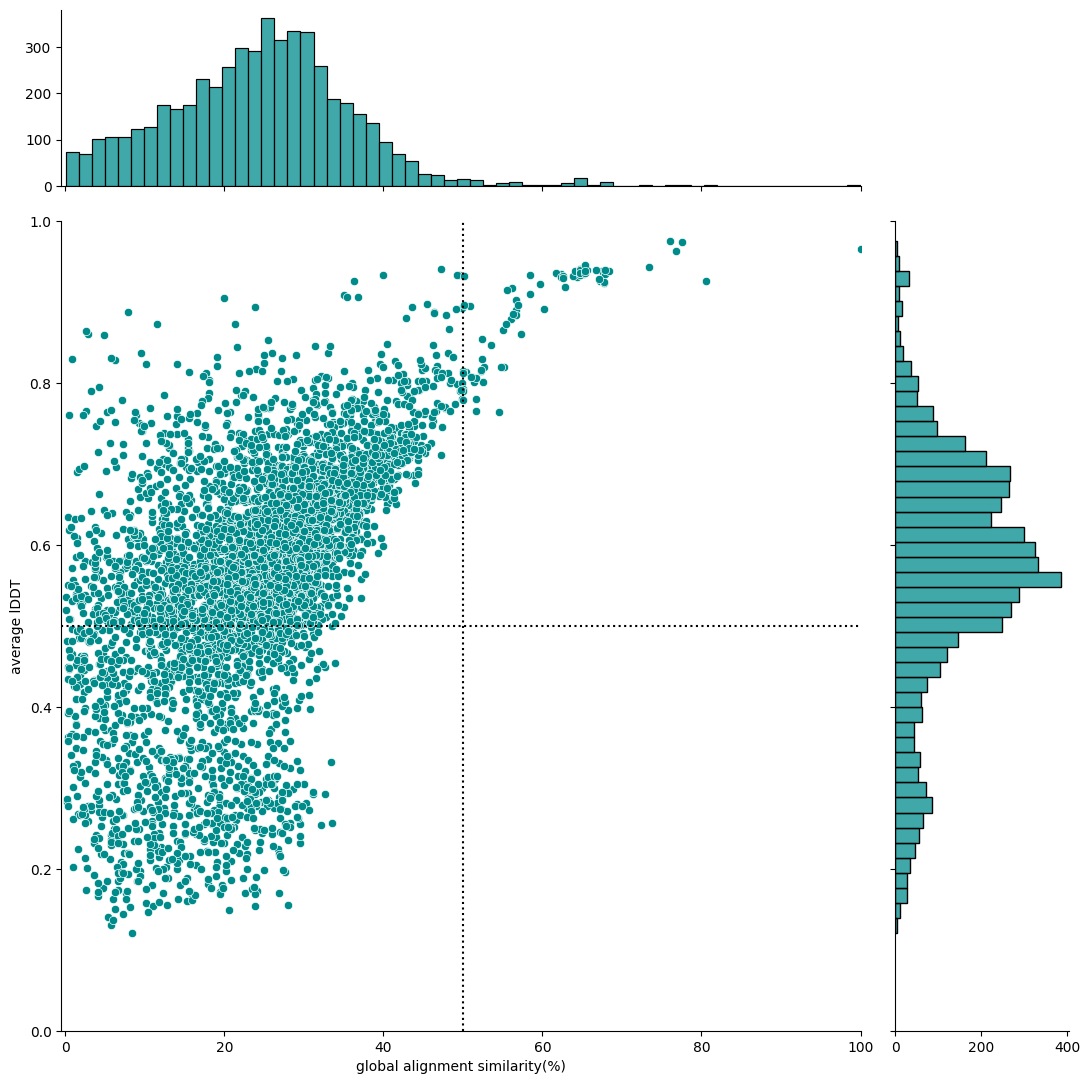

<Figure size 3500x3500 with 0 Axes>

In [30]:
plt.figure(figsize=(8, 8), dpi=500)

sns.jointplot(
    data=foldseek_filter_viz,
    x="Similarity_percent_needle",
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

plt.xlim(-0.5,100)
plt.ylim(0,1)
plt.xlabel("global alignment similarity(%)")
plt.ylabel("average lDDT")
# plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
# plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")
# plt.axhline(y=color_y, color="black", linestyle=":")
plt.figure(figsize=(7, 7), dpi=500)
plt.show()


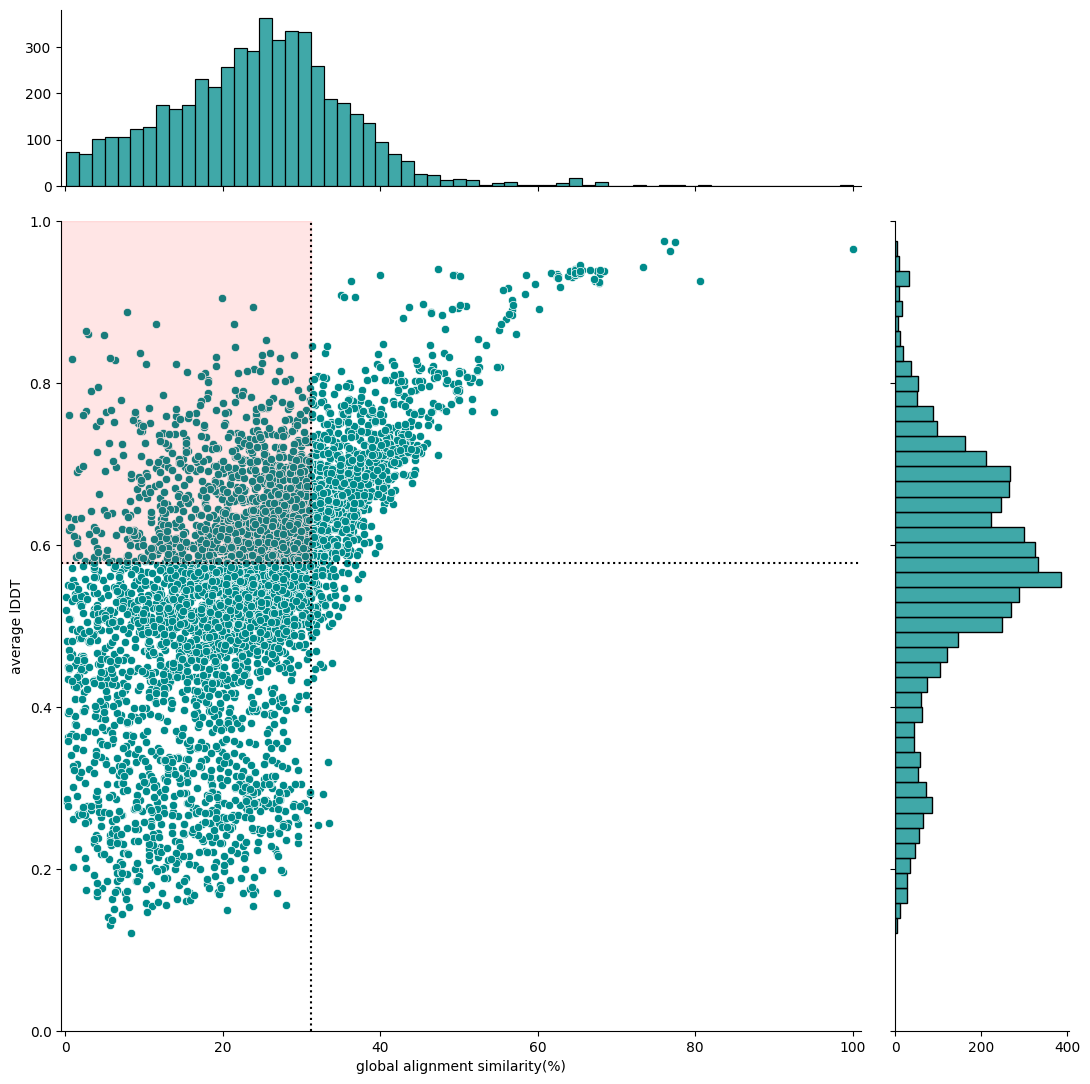

<Figure size 4000x4000 with 0 Axes>

In [31]:
sns.jointplot(
    data=foldseek_filter_viz,
    x="Similarity_percent_needle",
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

plt.fill_betweenx(
    y=[median_y, 1],
    x1=-0.5,
    x2=third_quartile,
    color="red",
    alpha=0.1
)

# plt.fill_betweenx(
#     y=[median_y, 1],
#     x1=-0.5,
#     x2=third_quartile,
#     color="orange",
#     alpha=0.1
# )

# plt.fill_betweenx(
#     y=[median_y, 1],
#     x1=third_quartile,
#     x2=100,
#     color="blue",
#     alpha=0.1
# )

plt.xlim(-0.5,101)
plt.ylim(0,1)
plt.xlabel("global alignment similarity(%)")
plt.ylabel("average lDDT")
plt.axhline(y=median_y, color="black", linestyle=":")
plt.axvline(x=third_quartile, color="black", linestyle=":")
plt.figure(figsize=(8, 8), dpi=500)
plt.show()


In [32]:
# top hit
foldseek_filter_viz_top = foldseek_filter_viz.filter(
    (pl.col("lddt") >= 0.9) &
    (pl.col("Similarity_percent_needle") > 90)
)

display(foldseek_filter_viz_top)

hit label,From,UniProt Accession,foldseek hit,pident,fident,qcov,tcov,rmsd,lddt,Identity_percent_needle,Identity_percent_water,Similarity_percent_needle,Similarity_percent_water
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""foldseek-hit-4247""","""Os02g0684500""","""Q7XUC9""","""P62805""",97.9,0.979,0.951,0.951,2.498,0.9659,98.1,98.1,100.0,100.0


&nbsp;

### Scatter Plot with boxplot


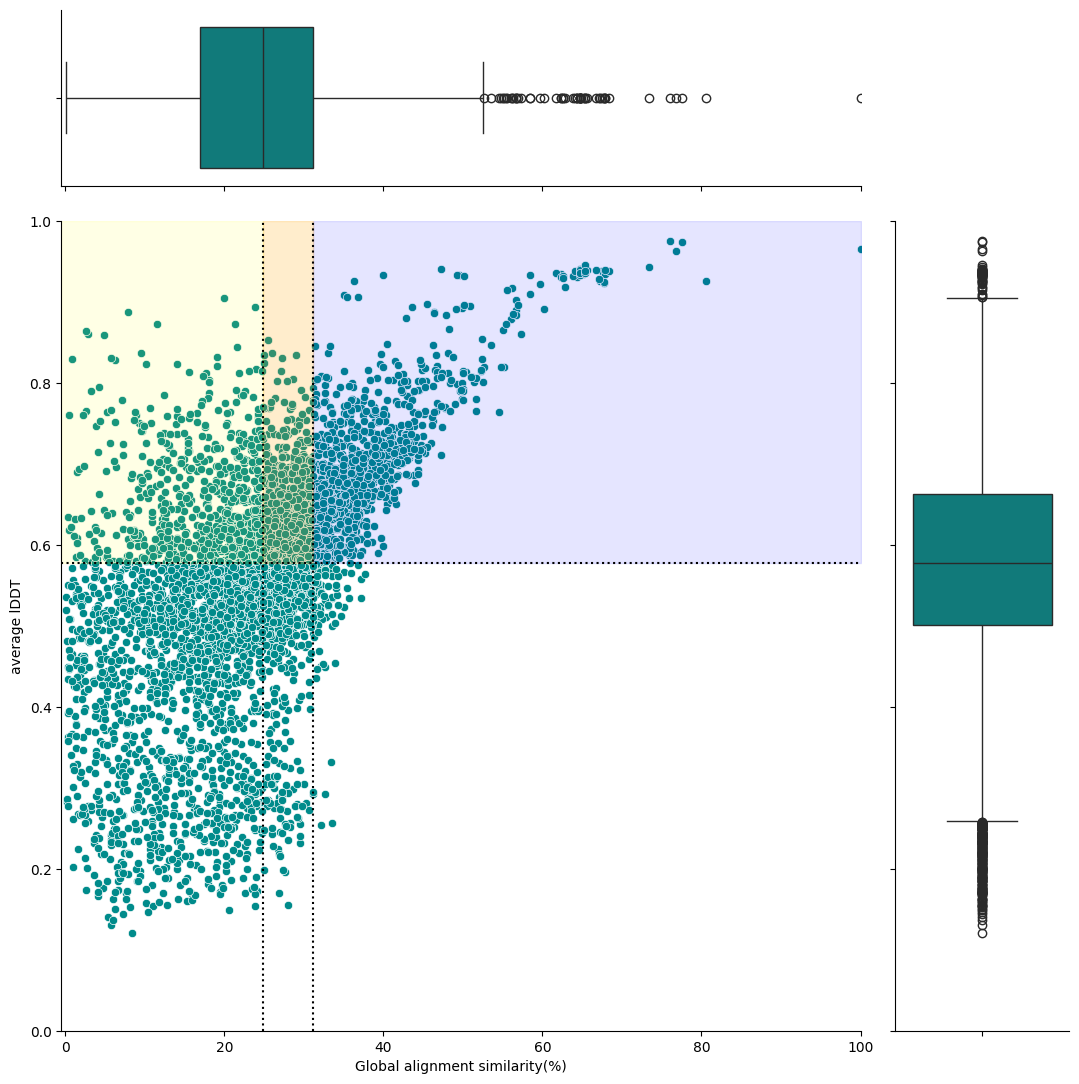

In [33]:
g = sns.JointGrid(
    data=foldseek_filter_viz,
    x="Similarity_percent_needle",
    y="lddt",
    height=11,
    ratio=4,
    marginal_ticks=True
)

# 散布図のプロット
g.plot_joint(sns.scatterplot, color="darkcyan")

# マージナルプロットを箱ひげ図に変更
g.plot_marginals(sns.boxplot, color="darkcyan")

# プロットの設定
g.ax_joint.set_xlim(-0.5, 100)
g.ax_joint.set_ylim(0, 1)
g.ax_joint.set_xlabel("Global alignment similarity(%)")
g.ax_joint.set_ylabel("average lDDT")

# 中央値を基にした範囲の塗りつぶし
g.ax_joint.fill_betweenx(
    y=[median_y, 1],
    x1=third_quartile,
    x2=100,
    color="blue",
    alpha=0.1
)

g.ax_joint.fill_betweenx(
    y=[median_y, 1],
    x1=median_x,
    x2=third_quartile,
    color="orange",
    alpha=0.2
)

g.ax_joint.fill_betweenx(
    y=[median_y, 1],
    x1=-0.5,
    x2=median_x,
    color="yellow",
    alpha=0.1
)

g.ax_joint.axvline(x=median_x, color="black", linestyle=":")
g.ax_joint.axhline(y=median_y, color="black", linestyle=":")
g.ax_joint.axvline(x=third_quartile, color="black", linestyle=":")
plt.show()

# Filtering hit

In [34]:
# 条件1: LDDT >= median_y & Identity > third_quartile
condition3_filter_1 = condition3.filter(
    (pl.col("lddt") >= median_y) & (pl.col("Similarity_percent_needle") > third_quartile)
)

print(condition3_filter_1.select("From").n_unique())
print(condition3_filter_1.select("From").unique().to_series().to_list())
display(condition3_filter_1)

85
['Os01g0871600', 'Os07g0190000', 'Os04g0578600', 'Os08g0101100', 'Os03g0237100', 'Os11g0210600', 'Os03g0760200', 'Os12g0610800', 'Os12g0441600', 'Os07g0561800', 'Os11g0439600', 'Os10g0531400', 'Os10g0144700', 'Os04g0339800', 'Os07g0258400', 'Os09g0424300', 'Os02g0306401', 'Os07g0257200', 'Os12g0123500', 'Os01g0192900', 'Os07g0129200', 'Os12g0194900', 'Os05g0475700', 'Os01g0613500', 'Os02g0191800', 'Os06g0694400', 'Os05g0592300', 'Os09g0551600', 'Os10g0528300', 'Os11g0151500', 'Os01g0854800', 'Os05g0106200', 'Os03g0210200', 'Os05g0482400', 'Os05g0113900', 'Os07g0524900', 'Os01g0232000', 'Os06g0129900', 'Os01g0382400', 'Os07g0622700', 'Os03g0162200', 'Os09g0567500', 'Os01g0871500', 'Os06g0210000', 'Os03g0431800', 'Os02g0226200', 'Os10g0165300', 'Os12g0512100', 'Os10g0530900', 'Os02g0149900', 'Os01g0279400', 'Os06g0228500', 'Os10g0456100', 'Os11g0134900', 'Os03g0634400', 'Os03g0404800', 'Os08g0455900', 'Os02g0791400', 'Os03g0667300', 'Os11g0286800', 'Os03g0332100', 'Os07g0292100', 'Os1

hit label,From,UniProt Accession,foldseek hit,ensembl_protein_id,ensembl_gene_id,hgnc_symbol_id,normalized TM-score,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,mismatch,qcov,tcov,rmsd,lddt,qtmscore,ttmscore,alntmscore,taxid,taxname,Length_water,Length_needle,Identity_water,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_percent_water,Gaps_needle,Gaps_percent_needle,Score_water,Score_needle
str,str,str,str,str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64
"""foldseek-hit-249""","""Os01g0192900""","""A0A0P0UZP7""","""P24298""","""ENSP00000378408""","""ENSG00000167701""","""GPT""",0.7556,0.956,28,17.2,0.172,85,79,525,533,12,496,496,492,355,0.839,0.978,3.452,0.6548,0.7426,0.7943,0.7943,9606,"""Homo sapiens""",398,598,"""96/398""",24.1,20.2,42.2,35.8,"""66/398""",16.6,"""167/598""",27.9,208.5,179.0
"""foldseek-hit-249""","""Os01g0192900""","""A0A0P0UZP7""","""P24298""","""ENSP00000433586""","""ENSG00000167701""","""GPT""",0.7556,0.956,28,17.2,0.172,85,79,525,533,12,496,496,492,355,0.839,0.978,3.452,0.6548,0.7426,0.7943,0.7943,9606,"""Homo sapiens""",398,598,"""96/398""",24.1,20.2,42.2,35.8,"""66/398""",16.6,"""167/598""",27.9,208.5,179.0
"""foldseek-hit-260""","""Os01g0192900""","""A0A0P0UZP7""","""Q4AC99""","""ENSP00000368109""","""ENSG00000205126""","""ACCSL""",0.741,0.971,12,28.0,0.28,128,86,533,533,131,568,568,456,302,0.841,0.771,2.087,0.7775,0.77,0.724,0.724,9606,"""Homo sapiens""",495,642,"""144/495""",29.1,23.5,46.5,37.4,"""53/495""",10.7,"""183/642""",28.5,528.5,522.0
"""foldseek-hit-296""","""Os01g0192900""","""A0A0P0UZP7""","""Q8TD30""","""ENSP00000413804""","""ENSG00000166123""","""GPT2""",0.7403,0.956,29,15.5,0.155,76,80,523,533,39,523,523,490,363,0.833,0.927,3.36,0.6556,0.7452,0.7586,0.7586,9606,"""Homo sapiens""",408,633,"""96/408""",23.5,18.5,39.5,32.5,"""86/408""",21.1,"""210/633""",33.2,183.0,156.5
"""foldseek-hit-296""","""Os01g0192900""","""A0A0P0UZP7""","""Q8TD30""","""ENSP00000345282""","""ENSG00000166123""","""GPT2""",0.7403,0.956,29,15.5,0.155,76,80,523,533,39,523,523,490,363,0.833,0.927,3.36,0.6556,0.7452,0.7586,0.7586,9606,"""Homo sapiens""",408,633,"""96/408""",23.5,18.5,39.5,32.5,"""86/408""",21.1,"""210/633""",33.2,183.0,156.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""foldseek-hit-15112""","""Os12g0512100""","""Q0IN24""","""X6RE50""","""ENSP00000395642""","""ENSG00000004809""","""SLC22A16""",0.7171,0.872,16,15.3,0.153,64,58,469,513,52,426,432,416,307,0.803,0.868,3.006,0.587,0.6677,0.7862,0.7862,9606,"""Homo sapiens""",428,537,"""104/428""",24.3,21.8,40.2,37.1,"""95/428""",22.2,"""129/537""",24.0,210.0,197.5
"""foldseek-hit-15477""","""Os12g0610800""","""Q0ILZ7""","""A0A384MDW1""","""ENSP00000506179""","""ENSG00000110079""","""MS4A4A""",0.5724,0.772,15,5.6,0.056,11,15,190,195,30,195,220,193,138,0.903,0.755,3.568,0.6133,0.6268,0.5628,0.5628,9606,"""Homo sapiens""",170,253,"""36/170""",21.2,17.0,47.1,37.9,"""42/170""",24.7,"""91/253""",36.0,71.5,55.5
"""foldseek-hit-15477""","""Os12g0610800""","""Q0ILZ7""","""A0A384MDW1""","""ENSP00000505293""","""ENSG00000110079""","""MS4A4A""",0.5724,0.772,15,5.6,0.056,11,15,190,195,30,195,220,193,138,0.903,0.755,3.568,0.6133,0.6268,0.5628,0.5628,9606,"""Homo sapiens""",170,253,"""36/170""",21.2,17.0,47.1,37.9,"""42/170""",24.7,"""91/253""",36.0,71.5,55.5


In [35]:
# 条件2: LDDT >= median_y & Identity <= median_x
condition3_filter_2 = condition3.filter(
    (pl.col("lddt") >= median_y) & (pl.col("Similarity_percent_needle") > median_x)
)

print(condition3_filter_2.select("From").n_unique())
print(condition3_filter_2.select("From").unique().to_series().to_list())
display(condition3_filter_2)

107
['Os06g0210000', 'Os07g0129200', 'Os04g0587500', 'Os06g0694400', 'Os09g0528700', 'Os02g0136933', 'Os01g0284500', 'Os01g0813800', 'Os11g0286800', 'Os09g0567500', 'Os05g0592300', 'Os06g0129900', 'Os01g0591300', 'Os02g0563000', 'Os03g0237100', 'Os09g0129500', 'Os10g0530900', 'Os07g0292100', 'Os09g0424300', 'Os06g0228500', 'Os03g0371000', 'Os08g0111200', 'Os10g0527800', 'Os07g0257200', 'Os02g0575200', 'Os05g0482400', 'Os02g0779400', 'Os04g0545600', 'Os12g0123500', 'Os01g0279400', 'Os01g0871600', 'Os11g0655900', 'Os11g0600500', 'Os09g0129800', 'Os10g0165300', 'Os12g0441600', 'Os05g0113900', 'Os12g0194900', 'Os07g0179300', 'Os03g0431800', 'Os08g0547800', 'Os01g0382400', 'Os08g0101100', 'Os02g0504000', 'Os01g0854800', 'Os10g0436900', 'Os09g0551600', 'Os08g0189300', 'Os03g0833100', 'Os12g0512100', 'Os03g0162200', 'Os07g0622700', 'Os07g0190000', 'Os09g0275400', 'Os11g0154900', 'Os11g0649600', 'Os02g0684500', 'Os10g0531400', 'Os01g0232000', 'Os03g0667300', 'Os11g0439600', 'Os02g0570700', 'Os

hit label,From,UniProt Accession,foldseek hit,ensembl_protein_id,ensembl_gene_id,hgnc_symbol_id,normalized TM-score,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,mismatch,qcov,tcov,rmsd,lddt,qtmscore,ttmscore,alntmscore,taxid,taxname,Length_water,Length_needle,Identity_water,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_percent_water,Gaps_needle,Gaps_percent_needle,Score_water,Score_needle
str,str,str,str,str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64
"""foldseek-hit-249""","""Os01g0192900""","""A0A0P0UZP7""","""P24298""","""ENSP00000378408""","""ENSG00000167701""","""GPT""",0.7556,0.956,28,17.2,0.172,85,79,525,533,12,496,496,492,355,0.839,0.978,3.452,0.6548,0.7426,0.7943,0.7943,9606,"""Homo sapiens""",398,598,"""96/398""",24.1,20.2,42.2,35.8,"""66/398""",16.6,"""167/598""",27.9,208.5,179.0
"""foldseek-hit-249""","""Os01g0192900""","""A0A0P0UZP7""","""P24298""","""ENSP00000433586""","""ENSG00000167701""","""GPT""",0.7556,0.956,28,17.2,0.172,85,79,525,533,12,496,496,492,355,0.839,0.978,3.452,0.6548,0.7426,0.7943,0.7943,9606,"""Homo sapiens""",398,598,"""96/398""",24.1,20.2,42.2,35.8,"""66/398""",16.6,"""167/598""",27.9,208.5,179.0
"""foldseek-hit-260""","""Os01g0192900""","""A0A0P0UZP7""","""Q4AC99""","""ENSP00000368109""","""ENSG00000205126""","""ACCSL""",0.741,0.971,12,28.0,0.28,128,86,533,533,131,568,568,456,302,0.841,0.771,2.087,0.7775,0.77,0.724,0.724,9606,"""Homo sapiens""",495,642,"""144/495""",29.1,23.5,46.5,37.4,"""53/495""",10.7,"""183/642""",28.5,528.5,522.0
"""foldseek-hit-296""","""Os01g0192900""","""A0A0P0UZP7""","""Q8TD30""","""ENSP00000413804""","""ENSG00000166123""","""GPT2""",0.7403,0.956,29,15.5,0.155,76,80,523,533,39,523,523,490,363,0.833,0.927,3.36,0.6556,0.7452,0.7586,0.7586,9606,"""Homo sapiens""",408,633,"""96/408""",23.5,18.5,39.5,32.5,"""86/408""",21.1,"""210/633""",33.2,183.0,156.5
"""foldseek-hit-296""","""Os01g0192900""","""A0A0P0UZP7""","""Q8TD30""","""ENSP00000345282""","""ENSG00000166123""","""GPT2""",0.7403,0.956,29,15.5,0.155,76,80,523,533,39,523,523,490,363,0.833,0.927,3.36,0.6556,0.7452,0.7586,0.7586,9606,"""Homo sapiens""",408,633,"""96/408""",23.5,18.5,39.5,32.5,"""86/408""",21.1,"""210/633""",33.2,183.0,156.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""foldseek-hit-15489""","""Os12g0610800""","""Q0ILZ7""","""Q01362""","""ENSP00000278888""","""ENSG00000149534""","""MS4A2""",0.547,0.747,14,6.7,0.067,13,11,188,195,40,209,244,193,142,0.913,0.697,3.98,0.6136,0.627,0.5148,0.5148,9606,"""Homo sapiens""",154,294,"""28/154""",18.2,13.3,35.1,27.6,"""57/154""",37.0,"""149/294""",50.7,55.5,37.5
"""foldseek-hit-15492""","""Os12g0610800""","""Q0ILZ7""","""Q7Z7N9""","""ENSP00000333697""","""ENSG00000185475""","""TMEM179B""",0.6282,0.887,12,12.2,0.122,25,22,191,195,3,194,219,204,133,0.872,0.877,3.556,0.6938,0.6815,0.613,0.613,9606,"""Homo sapiens""",182,268,"""43/182""",23.6,17.9,33.5,25.4,"""55/182""",30.2,"""122/268""",45.5,52.5,35.5
"""foldseek-hit-15493""","""Os12g0610800""","""Q0ILZ7""","""Q8N5U1""","""ENSP00000434165""","""ENSG00000166961""","""MS4A15""",0.5163,0.663,10,5.8,0.058,10,24,189,195,64,204,240,170,127,0.851,0.587,3.272,0.6017,0.5852,0.4856,0.4856,9606,"""Homo sapiens""",90,272,"""21/90""",23.3,16.5,35.6,26.5,"""25/90""",27.8,"""109/272""",40.1,36.0,23.5


In [36]:
condition3_filter_3 = condition3.filter(
    ((pl.col("lddt") >= median_y) &
    (pl.col("Similarity_percent_needle") <= median_x)) &
    (~pl.col("From").is_in(condition3_filter_2.select("From"))) & # 条件2 (LDDT >= median_y & Identity <= median_x) を除外
    (~pl.col("foldseek hit").is_in(condition3_filter_2.select("foldseek hit"))) # 
)

print(condition3_filter_3.select("From").n_unique())
print(condition3_filter_3.select("From").unique().to_series().to_list())
display(condition3_filter_3)

ComputeError: shapes don't match: expected 611 elements in 'is_in' comparison, got 1

In [27]:
condition3_filter_4 = condition3.filter(
    (pl.col("lddt") >= median_y) & (pl.col("Similarity_percent_needle") <= third_quartile) &
    (~pl.col("From").is_in(condition3_filter_1.select("From"))) & # 条件1 (LDDT >= median_y & Identity > third_quartile) を除外
    (~pl.col("foldseek hit").is_in(condition3_filter_1.select("foldseek hit"))) # 
)

print(condition3_filter_4.select("hit label").n_unique())
print(condition3_filter_4.select("hit label").unique().to_series().to_list())
display(condition3_filter_4)

157
['foldseek-hit-7643', 'foldseek-hit-13580', 'foldseek-hit-6053', 'foldseek-hit-2896', 'foldseek-hit-2847', 'foldseek-hit-5534', 'foldseek-hit-8411', 'foldseek-hit-8367', 'foldseek-hit-8358', 'foldseek-hit-8283', 'foldseek-hit-9398', 'foldseek-hit-4563', 'foldseek-hit-4067', 'foldseek-hit-2933', 'foldseek-hit-5911', 'foldseek-hit-6333', 'foldseek-hit-5903', 'foldseek-hit-4505', 'foldseek-hit-8406', 'foldseek-hit-621', 'foldseek-hit-2775', 'foldseek-hit-8281', 'foldseek-hit-2771', 'foldseek-hit-8374', 'foldseek-hit-6558', 'foldseek-hit-8394', 'foldseek-hit-3317', 'foldseek-hit-3272', 'foldseek-hit-4543', 'foldseek-hit-3319', 'foldseek-hit-5528', 'foldseek-hit-5517', 'foldseek-hit-9036', 'foldseek-hit-3380', 'foldseek-hit-5516', 'foldseek-hit-6039', 'foldseek-hit-2872', 'foldseek-hit-2864', 'foldseek-hit-5521', 'foldseek-hit-9417', 'foldseek-hit-8316', 'foldseek-hit-13337', 'foldseek-hit-4092', 'foldseek-hit-4546', 'foldseek-hit-5898', 'foldseek-hit-8291', 'foldseek-hit-6347', 'foldse

hit label,From,UniProt Accession,foldseek hit,ensembl_protein_id,ensembl_gene_id,hgnc_symbol_id,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,mismatch,qcov,tcov,rmsd,lddt,qtmscore,ttmscore,alntmscore,taxid,taxname,Length_water,Length_needle,Identity_water,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_percent_water,Gaps_needle,Gaps_percent_needle,Score_water,Score_needle
str,str,str,str,str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64
"""foldseek-hit-562""","""Os01g0279400""","""Q8H6D6""","""O15403""","""ENSP00000319991""","""ENSG00000108932""","""SLC16A6""",7.3770e-9,1.0,16,11.6,0.116,58,43,486,497,20,471,523,496,342,0.893,0.864,13.69,0.561,0.636,0.6068,0.7067,9606,"""Homo sapiens""",275,780,"""57/275""",20.7,8.8,33.5,14.1,"""97/275""",35.3,"""540/780""",69.2,98.0,70.5
"""foldseek-hit-562""","""Os01g0279400""","""Q8H6D6""","""O15403""","""ENSP00000462985""","""ENSG00000108932""","""SLC16A6""",7.3770e-9,1.0,16,11.6,0.116,58,43,486,497,20,471,523,496,342,0.893,0.864,13.69,0.561,0.636,0.6068,0.7067,9606,"""Homo sapiens""",275,780,"""57/275""",20.7,8.8,33.5,14.1,"""97/275""",35.3,"""540/780""",69.2,98.0,70.5
"""foldseek-hit-573""","""Os01g0279400""","""Q8H6D6""","""O76082""","""ENSP00000402760""","""ENSG00000197375""","""SLC22A5""",0.000003,1.0,21,11.5,0.115,64,48,497,497,19,515,557,556,327,0.905,0.892,10.41,0.5506,0.6014,0.5416,0.6592,9606,"""Homo sapiens""",486,687,"""98/486""",20.2,16.0,36.4,27.8,"""151/486""",31.1,"""320/687""",46.6,125.5,103.5
"""foldseek-hit-573""","""Os01g0279400""","""Q8H6D6""","""O76082""","""ENSP00000245407""","""ENSG00000197375""","""SLC22A5""",0.000003,1.0,21,11.5,0.115,64,48,497,497,19,515,557,556,327,0.905,0.892,10.41,0.5506,0.6014,0.5416,0.6592,9606,"""Homo sapiens""",486,687,"""98/486""",20.2,16.0,36.4,27.8,"""151/486""",31.1,"""320/687""",46.6,125.5,103.5
"""foldseek-hit-621""","""Os01g0279400""","""Q8H6D6""","""Q6NT16""","""ENSP00000275227""","""ENSG00000146409""","""SLC18B1""",0.000004,1.0,19,12.8,0.128,59,48,486,497,34,422,456,460,309,0.883,0.853,5.409,0.5534,0.6073,0.6556,0.7559,9606,"""Homo sapiens""",538,597,"""113/538""",21.0,19.8,34.2,32.3,"""201/538""",37.4,"""241/597""",40.4,129.5,120.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""foldseek-hit-13580""","""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""","""ENSP00000485891""","""ENSG00000276342""","""TMEM179""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,133,0.821,0.807,6.032,0.5904,0.5441,0.4651,0.6474,9606,"""Homo sapiens""",29,308,"""9/29""",31.0,10.4,55.2,17.5,"""4/29""",13.8,"""188/308""",61.0,34.5,21.5
"""foldseek-hit-13580""","""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""","""ENSP00000450958""","""ENSG00000258986""","""TMEM179""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,133,0.821,0.807,6.032,0.5904,0.5441,0.4651,0.6474,9606,"""Homo sapiens""",29,308,"""9/29""",31.0,10.4,55.2,17.5,"""4/29""",13.8,"""188/308""",61.0,34.5,21.5
"""foldseek-hit-13580""","""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""","""ENSP00000340477""","""ENSG00000258986""","""TMEM179""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,133,0.821,0.807,6.032,0.5904,0.5441,0.4651,0.6474,9606,"""Homo sapiens""",29,308,"""9/29""",31.0,10.4,55.2,17.5,"""4/29""",13.8,"""188/308""",61.0,34.5,21.5


&nbsp;

&nbsp;

&nbsp;

&nbsp;

# Custom Analysis: Domain Information

In [28]:
# rice domain information
uniprot_info_rice = pl.read_csv(
    query_idmapping_tsv_path,
    separator='\t'
)

domain_info_rice = uniprot_info_rice.select(
    "From",
    "InterPro"
).rename(
    {
        "From": "UniProt Accession",
        "InterPro": "InterPro_rice"
    }
).with_columns(
    pl.col("InterPro_rice").str.strip_suffix(";")
).with_columns(
    pl.col("InterPro_rice").str.split(";").cast(pl.List(pl.Utf8))
)

# human domain information
uniprot_info_human = pl.read_csv(
    target_idmapping_tsv_path,
    separator='\t'
)

domain_info_human = uniprot_info_human.select(
    "From",
    "InterPro"
).rename(
    {
        "From": "foldseek hit",
        "InterPro": "InterPro_human"
    }
).with_columns(
    pl.col("InterPro_human").str.strip_suffix(";")
).with_columns(
    pl.col("InterPro_human").str.split(";").cast(pl.List(pl.Utf8))
)

display(domain_info_rice)
display(domain_info_human)

UniProt Accession,InterPro_rice
str,list[str]
"""A0A0P0UWX1""",null
"""A0A8J8YJH9""",null
"""Q5ZC68""",null
"""A0A0P0UXR3""","[""IPR011009"", ""IPR045874"", … ""IPR008271""]"
"""B7FAP2""","[""IPR002213"", ""IPR035595""]"
…,…
"""A0A0N7KUC5""",null
"""Q0ILR1""","[""IPR037176"", ""IPR001938"", ""IPR017949""]"
"""Q2QLS8""","[""IPR037176"", ""IPR001938"", ""IPR017949""]"


foldseek hit,InterPro_human
str,list[str]
"""A0A023PX70""","[""IPR011009"", ""IPR050198"", … ""IPR020635""]"
"""A0A024CIM4""","[""IPR029058"", ""IPR050654"", … ""IPR000997""]"
"""A0A024QY88""","[""IPR000742"", ""IPR007110"", … ""IPR040180""]"
"""A0A024QYV1""",null
"""A0A024QYY0""",null
…,…
"""X6RE50""","[""IPR020846"", ""IPR005828"", ""IPR036259""]"
"""X6RGV9""","[""IPR026610"", ""IPR029063""]"
"""X6RI37""","[""IPR001611"", ""IPR003591"", … ""IPR050216""]"


In [29]:
domain_info = condition3.join(
    domain_info_rice,
    on="UniProt Accession",
    how="left",
    coalesce=True,
    validate="m:m"
).join(
    domain_info_human,
    on="foldseek hit",
    how="left",
    coalesce=True,
    validate="m:m"
).with_columns(
    pl.col("InterPro_rice").list.set_intersection("InterPro_human").alias("InterPro ID intersection"),
    pl.col("InterPro_rice").list.set_intersection("InterPro_human").list.len().alias("InterPro ID intersection count")
).sort(
    by=["InterPro ID intersection count"],
    descending=[True]
).with_columns(
    pl.when(
        (pl.col("InterPro_rice").is_null()) | (pl.col("InterPro_human").is_null())
    ).then(
        pl.lit("missing InterPro entry in rice or human")
    ).when(
        pl.col("InterPro ID intersection count") == 0
    ).then(
        pl.lit("no common InterPro ID")
    ).otherwise(
        pl.lit("have common InterPro ID")
    ).alias("InterPro ID intersection tag")
).sort(
    by=["From", "UniProt Accession", "foldseek hit"],
    descending=[False, False, False]
)

display(domain_info)

hit label,From,UniProt Accession,foldseek hit,ensembl_protein_id,ensembl_gene_id,hgnc_symbol_id,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,mismatch,qcov,tcov,rmsd,lddt,qtmscore,ttmscore,alntmscore,taxid,taxname,Length_water,Length_needle,Identity_water,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_percent_water,Gaps_needle,Gaps_percent_needle,Score_water,Score_needle,InterPro_rice,InterPro_human,InterPro ID intersection,InterPro ID intersection count,InterPro ID intersection tag
str,str,str,str,str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64,list[str],list[str],list[str],u32,str
"""foldseek-hit-4""","""Os01g0179600""","""B7FAP2""","""A0A140T9Z0""","""ENSP00000425497""","""ENSG00000173610""","""UGT2A1""",4.8950e-7,1.0,38,12.4,0.124,87,7,486,487,14,634,693,700,314,0.986,0.896,28.01,0.3342,0.2238,0.1621,0.2273,9606,"""Homo sapiens""",320,775,"""74/320""",23.1,15.7,33.4,25.7,"""116/320""",36.2,"""370/775""",47.7,126.0,89.5,"[""IPR002213"", ""IPR035595""]","[""IPR050271"", ""IPR002213"", ""IPR035595""]","[""IPR002213"", ""IPR035595""]",2,"""have common InterPro ID"""
"""foldseek-hit-56""","""Os01g0179600""","""B7FAP2""","""O60656""","""ENSP00000346768""","""ENSG00000241119""","""UGT1A9""",8.7590e-15,1.0,31,14.6,0.146,78,11,486,487,23,465,530,532,309,0.977,0.836,7.592,0.4974,0.5927,0.5506,0.6454,9606,"""Homo sapiens""",177,643,"""46/177""",26.0,15.9,43.5,27.7,"""30/177""",16.9,"""269/643""",41.8,145.5,121.0,"[""IPR002213"", ""IPR035595""]","[""IPR050271"", ""IPR002213"", ""IPR035595""]","[""IPR002213"", ""IPR035595""]",2,"""have common InterPro ID"""
"""foldseek-hit-58""","""Os01g0179600""","""B7FAP2""","""O75310""","""ENSP00000387683""","""ENSG00000213759""","""UGT2B11""",9.1720e-13,1.0,30,12.6,0.126,68,8,484,487,18,467,529,536,323,0.979,0.851,8.478,0.4855,0.5713,0.5306,0.6146,9606,"""Homo sapiens""",200,689,"""55/200""",27.5,13.5,41.5,23.5,"""36/200""",18.0,"""362/689""",52.5,135.0,82.0,"[""IPR002213"", ""IPR035595""]","[""IPR050271"", ""IPR002213"", ""IPR035595""]","[""IPR002213"", ""IPR035595""]",2,"""have common InterPro ID"""
"""foldseek-hit-60""","""Os01g0179600""","""B7FAP2""","""O75795""","""ENSP00000320401""","""ENSG00000197888""","""UGT2B17""",6.2530e-13,1.0,29,13.3,0.133,72,10,486,487,20,471,530,540,317,0.979,0.853,8.602,0.4812,0.5687,0.5268,0.6088,9606,"""Homo sapiens""",219,711,"""54/219""",24.7,12.8,42.0,21.2,"""24/219""",11.0,"""405/711""",57.0,137.5,96.5,"[""IPR002213"", ""IPR035595""]","[""IPR050271"", ""IPR002213"", ""IPR035595""]","[""IPR002213"", ""IPR035595""]",2,"""have common InterPro ID"""
"""foldseek-hit-62""","""Os01g0179600""","""B7FAP2""","""P06133""","""ENSP00000421290""","""ENSG00000156096""","""UGT2B4""",1.2110e-13,1.0,32,12.3,0.123,66,9,486,487,19,470,528,534,330,0.982,0.856,11.88,0.4475,0.5181,0.4819,0.5542,9606,"""Homo sapiens""",208,653,"""55/208""",26.4,15.2,38.9,27.4,"""48/208""",23.1,"""291/653""",44.6,137.5,83.0,"[""IPR002213"", ""IPR035595""]","[""IPR050271"", ""IPR002213"", ""IPR035595""]","[""IPR002213"", ""IPR035595""]",2,"""have common InterPro ID"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""foldseek-hit-13580""","""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""","""ENSP00000485891""","""ENSG00000276342""","""TMEM179""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,133,0.821,0.807,6.032,0.5904,0.5441,0.4651,0.6474,9606,"""Homo sapiens""",29,308,"""9/29""",31.0,10.4,55.2,17.5,"""4/29""",13.8,"""188/308""",61.0,34.5,21.5,"[""IPR006459"", ""IPR006702"", ""IPR044173""]","[""IPR029673""]",[],0,"""no common InterPro ID"""
"""foldseek-hit-13580""","""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""","""ENSP00000450958""","""ENSG00000258986""","""TMEM179""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,133,0.821,0.807,6.032,0.590

### Filtering hit for upset plot

In [30]:
have_domain_info = domain_info.filter(
    (pl.col("InterPro ID intersection tag") == "have common InterPro ID")
)

display(have_domain_info)

hit label,From,UniProt Accession,foldseek hit,ensembl_protein_id,ensembl_gene_id,hgnc_symbol_id,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,mismatch,qcov,tcov,rmsd,lddt,qtmscore,ttmscore,alntmscore,taxid,taxname,Length_water,Length_needle,Identity_water,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_percent_water,Gaps_needle,Gaps_percent_needle,Score_water,Score_needle,InterPro_rice,InterPro_human,InterPro ID intersection,InterPro ID intersection count,InterPro ID intersection tag
str,str,str,str,str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64,list[str],list[str],list[str],u32,str
"""foldseek-hit-4""","""Os01g0179600""","""B7FAP2""","""A0A140T9Z0""","""ENSP00000425497""","""ENSG00000173610""","""UGT2A1""",4.8950e-7,1.0,38,12.4,0.124,87,7,486,487,14,634,693,700,314,0.986,0.896,28.01,0.3342,0.2238,0.1621,0.2273,9606,"""Homo sapiens""",320,775,"""74/320""",23.1,15.7,33.4,25.7,"""116/320""",36.2,"""370/775""",47.7,126.0,89.5,"[""IPR002213"", ""IPR035595""]","[""IPR050271"", ""IPR002213"", ""IPR035595""]","[""IPR002213"", ""IPR035595""]",2,"""have common InterPro ID"""
"""foldseek-hit-56""","""Os01g0179600""","""B7FAP2""","""O60656""","""ENSP00000346768""","""ENSG00000241119""","""UGT1A9""",8.7590e-15,1.0,31,14.6,0.146,78,11,486,487,23,465,530,532,309,0.977,0.836,7.592,0.4974,0.5927,0.5506,0.6454,9606,"""Homo sapiens""",177,643,"""46/177""",26.0,15.9,43.5,27.7,"""30/177""",16.9,"""269/643""",41.8,145.5,121.0,"[""IPR002213"", ""IPR035595""]","[""IPR050271"", ""IPR002213"", ""IPR035595""]","[""IPR002213"", ""IPR035595""]",2,"""have common InterPro ID"""
"""foldseek-hit-58""","""Os01g0179600""","""B7FAP2""","""O75310""","""ENSP00000387683""","""ENSG00000213759""","""UGT2B11""",9.1720e-13,1.0,30,12.6,0.126,68,8,484,487,18,467,529,536,323,0.979,0.851,8.478,0.4855,0.5713,0.5306,0.6146,9606,"""Homo sapiens""",200,689,"""55/200""",27.5,13.5,41.5,23.5,"""36/200""",18.0,"""362/689""",52.5,135.0,82.0,"[""IPR002213"", ""IPR035595""]","[""IPR050271"", ""IPR002213"", ""IPR035595""]","[""IPR002213"", ""IPR035595""]",2,"""have common InterPro ID"""
"""foldseek-hit-60""","""Os01g0179600""","""B7FAP2""","""O75795""","""ENSP00000320401""","""ENSG00000197888""","""UGT2B17""",6.2530e-13,1.0,29,13.3,0.133,72,10,486,487,20,471,530,540,317,0.979,0.853,8.602,0.4812,0.5687,0.5268,0.6088,9606,"""Homo sapiens""",219,711,"""54/219""",24.7,12.8,42.0,21.2,"""24/219""",11.0,"""405/711""",57.0,137.5,96.5,"[""IPR002213"", ""IPR035595""]","[""IPR050271"", ""IPR002213"", ""IPR035595""]","[""IPR002213"", ""IPR035595""]",2,"""have common InterPro ID"""
"""foldseek-hit-62""","""Os01g0179600""","""B7FAP2""","""P06133""","""ENSP00000421290""","""ENSG00000156096""","""UGT2B4""",1.2110e-13,1.0,32,12.3,0.123,66,9,486,487,19,470,528,534,330,0.982,0.856,11.88,0.4475,0.5181,0.4819,0.5542,9606,"""Homo sapiens""",208,653,"""55/208""",26.4,15.2,38.9,27.4,"""48/208""",23.1,"""291/653""",44.6,137.5,83.0,"[""IPR002213"", ""IPR035595""]","[""IPR050271"", ""IPR002213"", ""IPR035595""]","[""IPR002213"", ""IPR035595""]",2,"""have common InterPro ID"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""foldseek-hit-13517""","""Os12g0555500""","""B9GDP9""","""I3L3H0""","""ENSP00000460437""","""ENSG00000141179""","""PCTP""",0.003647,1.0,11,10.9,0.109,19,5,158,158,53,219,219,173,129,0.975,0.763,9.723,0.4294,0.4915,0.3754,0.5037,9606,"""Homo sapiens""",127,261,"""32/127""",25.2,12.6,40.9,20.7,"""17/127""",13.4,"""145/261""",55.6,45.0,27.5,"[""IPR000916"", ""IPR024949"", … ""IPR023393""]","[""IPR041950"", ""IPR023393"", … ""IPR051213""]","[""IPR023393""]",1,"""have common InterPro ID"""
"""foldseek-hit-13512""","""Os12g0555500""","""Q2QNS7""","""G3V438""","""ENSP00000451569""","""ENSG00000100591""","""AHSA1""",0.0001922,1.0,13,10.8,0.108

In [31]:
no_domain_info = domain_info.filter(
    ((pl.col("InterPro ID intersection tag") == "missing InterPro entry in rice or human") |
    (pl.col("InterPro ID intersection tag") == "no common InterPro ID")) &
    (~pl.col("From").is_in(have_domain_info.select("From")))
).sort(
    by=["lddt"],
    descending=[True]
)

print(no_domain_info.select("From").n_unique())
print(no_domain_info.select("From").unique().to_series().to_list())
# display(no_domain_info)

20
['Os05g0367900', 'Os11g0649600', 'Os05g0551000', 'Os02g0649900', 'Os03g0431800', 'Os11g0154900', 'Os01g0944700', 'Os06g0278000', 'Os04g0340300', 'Os02g0650300', 'Os01g0795200', 'Os04g0587500', 'Os04g0545600', 'Os04g0400000', 'Os07g0524200', 'Os12g0610800', 'Os04g0468600', 'Os01g0248300', 'Os01g0940700', 'Os11g0649700']


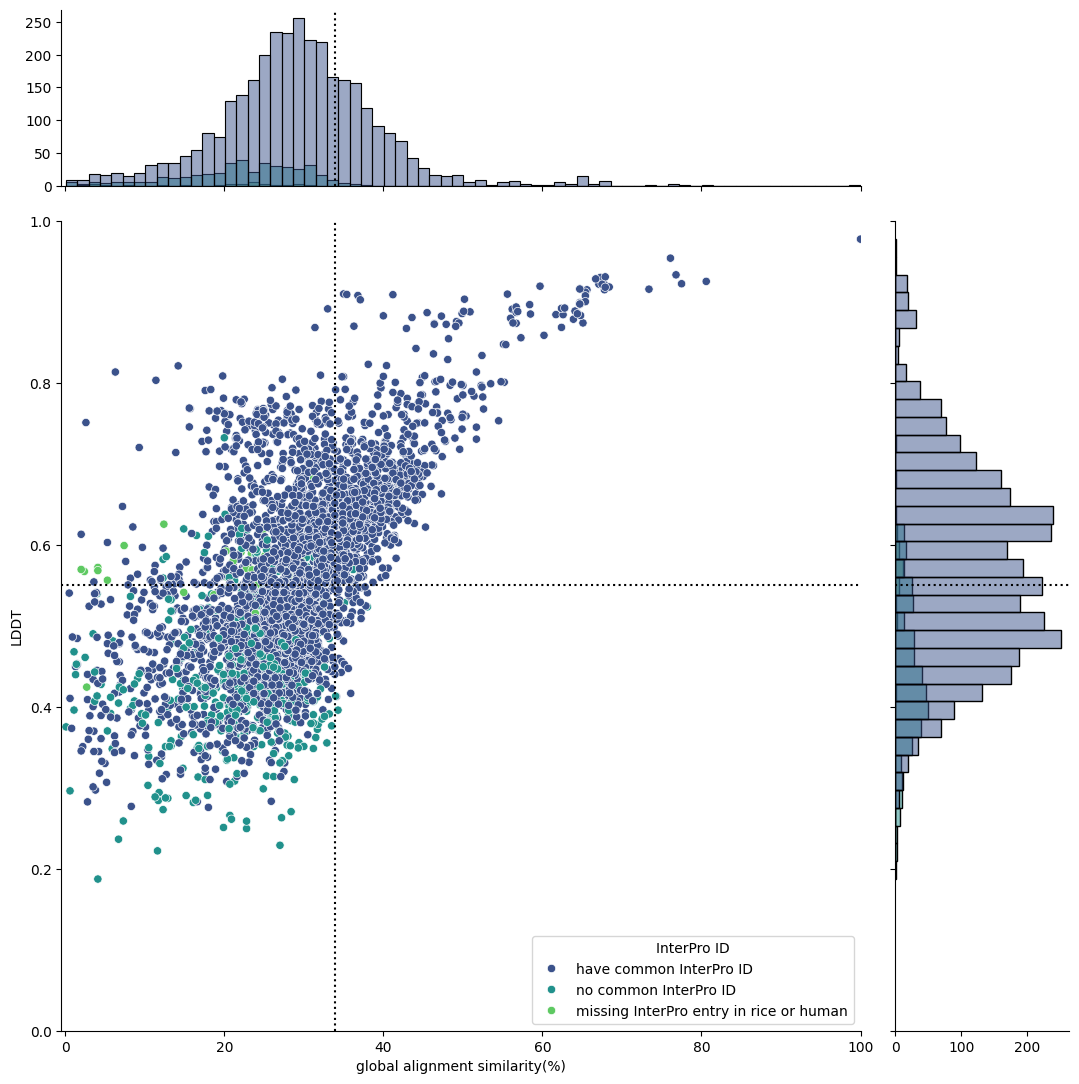

In [32]:
domain_info_viz = domain_info.select(
    "From",
    "UniProt Accession",
    "foldseek hit",
    "qcov",
    "tcov",
    "rmsd",
    "lddt",
    "Identity_percent_needle",
    "Identity_percent_water",
    "Similarity_percent_needle",
    "Similarity_percent_water",
    "InterPro ID intersection tag"
).unique().sort(
    by=["From"],
    descending=[False]
)

g = sns.JointGrid(
    data=domain_info_viz,
    x="Similarity_percent_needle",
    y="lddt",
    hue="InterPro ID intersection tag",
    height=11,
    dropna=False,
    ratio=4,
    palette="viridis",
    marginal_ticks=True
)
g.ax_joint.set_xlim(-0.5,100)
g.ax_joint.set_ylim(0,1)
g.ax_joint.set_xlabel("global alignment similarity(%)")
g.ax_joint.set_ylabel("LDDT")

# g.refline(x=25, color="black", linestyle=":")
# g.refline(x=50, color="black", linestyle=":")
# g.refline(x=75, color="black", linestyle=":")
# g.refline(y=0.5, color="black", linestyle=":")
g.refline(x=third_quartile, color="black", linestyle=":")
g.refline(y=median_y, color="black", linestyle=":")
g.plot(sns.scatterplot, sns.histplot)
handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(handles=handles, labels=labels, title='InterPro ID')

plt.show()

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;





&nbsp;

# Custom Analysis: Ensembl pan-homology information

- Ensembl pan-homologyの情報を追加する

In [33]:
ensembl_pan_homology = pl.read_csv(
    pan_homology_tsv_path,
    separator='\t'
).rename(
    {
        "target_id": "ensembl_gene_id",
        "target_protein_id": "ensembl_protein_id"
    }
).select(
    "From",
    "method_link_type",
    "type",
    "ensembl_gene_id",
    "ensembl_protein_id"
)

print(ensembl_pan_homology.group_by(["From"], maintain_order=True).n_unique())
display(ensembl_pan_homology)

shape: (98, 5)
┌──────────────┬──────────────────┬──────┬─────────────────┬────────────────────┐
│ From         ┆ method_link_type ┆ type ┆ ensembl_gene_id ┆ ensembl_protein_id │
│ ---          ┆ ---              ┆ ---  ┆ ---             ┆ ---                │
│ str          ┆ u32              ┆ u32  ┆ u32             ┆ u32                │
╞══════════════╪══════════════════╪══════╪═════════════════╪════════════════════╡
│ Os01g0179600 ┆ 1                ┆ 1    ┆ 22              ┆ 22                 │
│ Os01g0192900 ┆ 1                ┆ 1    ┆ 8               ┆ 8                  │
│ Os01g0216000 ┆ 1                ┆ 1    ┆ 14              ┆ 14                 │
│ Os01g0232000 ┆ 1                ┆ 1    ┆ 12              ┆ 12                 │
│ Os01g0279400 ┆ 1                ┆ 1    ┆ 2               ┆ 2                  │
│ …            ┆ …                ┆ …    ┆ …               ┆ …                  │
│ Os12g0194900 ┆ 1                ┆ 1    ┆ 16              ┆ 16                 │
│

From,method_link_type,type,ensembl_gene_id,ensembl_protein_id
str,str,str,str,str
"""Os01g0179600""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000135226""","""ENSP00000334276"""
"""Os01g0179600""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000171234""","""ENSP00000304811"""
"""Os01g0179600""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000135220""","""ENSP00000251566"""
"""Os01g0179600""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000213759""","""ENSP00000387683"""
"""Os01g0179600""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000173610""","""ENSP00000286604"""
…,…,…,…,…
"""Os12g0601800""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000182158""","""ENSP00000329140"""
"""Os12g0601800""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000107175""","""ENSP00000342136"""
"""Os12g0601800""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000157613""","""ENSP00000481956"""


In [34]:
display(condition3)

hit label,From,UniProt Accession,foldseek hit,ensembl_protein_id,ensembl_gene_id,hgnc_symbol_id,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,mismatch,qcov,tcov,rmsd,lddt,qtmscore,ttmscore,alntmscore,taxid,taxname,Length_water,Length_needle,Identity_water,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_percent_water,Gaps_needle,Gaps_percent_needle,Score_water,Score_needle
str,str,str,str,str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64
"""foldseek-hit-4""","""Os01g0179600""","""B7FAP2""","""A0A140T9Z0""","""ENSP00000425497""","""ENSG00000173610""","""UGT2A1""",4.8950e-7,1.0,38,12.4,0.124,87,7,486,487,14,634,693,700,314,0.986,0.896,28.01,0.3342,0.2238,0.1621,0.2273,9606,"""Homo sapiens""",320,775,"""74/320""",23.1,15.7,33.4,25.7,"""116/320""",36.2,"""370/775""",47.7,126.0,89.5
"""foldseek-hit-35""","""Os01g0179600""","""Q0JQ63""","""B7Z8Q8""","""ENSP00000427079""","""ENSG00000145626""","""UGT3A1""",3.8470e-12,1.0,28,14.0,0.14,71,9,452,487,18,433,436,504,285,0.912,0.954,7.146,0.4899,0.5429,0.5982,0.6249,9606,"""Homo sapiens""",213,580,"""57/213""",26.8,16.2,40.8,28.8,"""53/213""",24.9,"""237/580""",40.9,151.0,132.5
"""foldseek-hit-56""","""Os01g0179600""","""B7FAP2""","""O60656""","""ENSP00000346768""","""ENSG00000241119""","""UGT1A9""",8.7590e-15,1.0,31,14.6,0.146,78,11,486,487,23,465,530,532,309,0.977,0.836,7.592,0.4974,0.5927,0.5506,0.6454,9606,"""Homo sapiens""",177,643,"""46/177""",26.0,15.9,43.5,27.7,"""30/177""",16.9,"""269/643""",41.8,145.5,121.0
"""foldseek-hit-58""","""Os01g0179600""","""B7FAP2""","""O75310""","""ENSP00000387683""","""ENSG00000213759""","""UGT2B11""",9.1720e-13,1.0,30,12.6,0.126,68,8,484,487,18,467,529,536,323,0.979,0.851,8.478,0.4855,0.5713,0.5306,0.6146,9606,"""Homo sapiens""",200,689,"""55/200""",27.5,13.5,41.5,23.5,"""36/200""",18.0,"""362/689""",52.5,135.0,82.0
"""foldseek-hit-60""","""Os01g0179600""","""B7FAP2""","""O75795""","""ENSP00000320401""","""ENSG00000197888""","""UGT2B17""",6.2530e-13,1.0,29,13.3,0.133,72,10,486,487,20,471,530,540,317,0.979,0.853,8.602,0.4812,0.5687,0.5268,0.6088,9606,"""Homo sapiens""",219,711,"""54/219""",24.7,12.8,42.0,21.2,"""24/219""",11.0,"""405/711""",57.0,137.5,96.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""foldseek-hit-13580""","""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""","""ENSP00000485891""","""ENSG00000276342""","""TMEM179""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,133,0.821,0.807,6.032,0.5904,0.5441,0.4651,0.6474,9606,"""Homo sapiens""",29,308,"""9/29""",31.0,10.4,55.2,17.5,"""4/29""",13.8,"""188/308""",61.0,34.5,21.5
"""foldseek-hit-13580""","""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""","""ENSP00000450958""","""ENSG00000258986""","""TMEM179""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,133,0.821,0.807,6.032,0.5904,0.5441,0.4651,0.6474,9606,"""Homo sapiens""",29,308,"""9/29""",31.0,10.4,55.2,17.5,"""4/29""",13.8,"""188/308""",61.0,34.5,21.5
"""foldseek-hit-13580""","""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""","""ENSP00000340477""","""ENSG00000258986""","""TMEM179""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,133,0.821,0.807,6.032,0.5904,0.5441,0.4651,0.6474,9606,"""Homo sapiens""",29,308,"""9/29""",31.0,10.4,55.2,17.5,"""4/29""",13.8,"""188/308""",61.0,34.5,21.5


In [35]:
ensembl_pan_homology_info = condition3.join(
    ensembl_pan_homology,
    on=["From", "ensembl_protein_id", "ensembl_gene_id"],
    how="left",
    coalesce=True,
    validate="m:m"
).filter(
    (pl.col("method_link_type").is_not_null())
).sort(
    by=["From", "UniProt Accession", "foldseek hit"],
    descending=[False, False, False]
)

ensembl_pan_homology_info.write_csv(
    "../out/rice_up/ensembl_pan_homology_info.tsv",
    separator="\t"
)

display(ensembl_pan_homology_info)

hit label,From,UniProt Accession,foldseek hit,ensembl_protein_id,ensembl_gene_id,hgnc_symbol_id,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,mismatch,qcov,tcov,rmsd,lddt,qtmscore,ttmscore,alntmscore,taxid,taxname,Length_water,Length_needle,Identity_water,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_percent_water,Gaps_needle,Gaps_percent_needle,Score_water,Score_needle,method_link_type,type
str,str,str,str,str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64,str,str
"""foldseek-hit-56""","""Os01g0179600""","""B7FAP2""","""O60656""","""ENSP00000346768""","""ENSG00000241119""","""UGT1A9""",8.7590e-15,1.0,31,14.6,0.146,78,11,486,487,23,465,530,532,309,0.977,0.836,7.592,0.4974,0.5927,0.5506,0.6454,9606,"""Homo sapiens""",177,643,"""46/177""",26.0,15.9,43.5,27.7,"""30/177""",16.9,"""269/643""",41.8,145.5,121.0,"""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many"""
"""foldseek-hit-58""","""Os01g0179600""","""B7FAP2""","""O75310""","""ENSP00000387683""","""ENSG00000213759""","""UGT2B11""",9.1720e-13,1.0,30,12.6,0.126,68,8,484,487,18,467,529,536,323,0.979,0.851,8.478,0.4855,0.5713,0.5306,0.6146,9606,"""Homo sapiens""",200,689,"""55/200""",27.5,13.5,41.5,23.5,"""36/200""",18.0,"""362/689""",52.5,135.0,82.0,"""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many"""
"""foldseek-hit-60""","""Os01g0179600""","""B7FAP2""","""O75795""","""ENSP00000320401""","""ENSG00000197888""","""UGT2B17""",6.2530e-13,1.0,29,13.3,0.133,72,10,486,487,20,471,530,540,317,0.979,0.853,8.602,0.4812,0.5687,0.5268,0.6088,9606,"""Homo sapiens""",219,711,"""54/219""",24.7,12.8,42.0,21.2,"""24/219""",11.0,"""405/711""",57.0,137.5,96.5,"""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many"""
"""foldseek-hit-62""","""Os01g0179600""","""B7FAP2""","""P06133""","""ENSP00000305221""","""ENSG00000156096""","""UGT2B4""",1.2110e-13,1.0,32,12.3,0.123,66,9,486,487,19,470,528,534,330,0.982,0.856,11.88,0.4475,0.5181,0.4819,0.5542,9606,"""Homo sapiens""",208,653,"""55/208""",26.4,15.2,38.9,27.4,"""48/208""",23.1,"""291/653""",44.6,137.5,83.0,"""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many"""
"""foldseek-hit-64""","""Os01g0179600""","""B7FAP2""","""P0DTE4""","""ENSP00000286604""","""ENSG00000173610""","""UGT2A1""",2.3350e-13,1.0,31,12.3,0.123,66,8,486,487,15,468,527,533,334,0.984,0.861,11.26,0.4573,0.5448,0.509,0.5805,9606,"""Homo sapiens""",94,685,"""34/94""",36.2,14.5,50.0,24.5,"""5/94""",5.3,"""356/685""",52.0,121.0,71.0,"""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""foldseek-hit-13229""","""Os12g0512100""","""Q0IN24""","""Q96QE2""","""ENSP00000280871""","""ENSG00000151229""","""SLC2A13""",3.1830e-24,1.0,12,26.3,0.263,155,1,502,513,45,610,648,589,324,0.979,0.873,5.048,0.808,0.8614,0.6864,0.8815,9606,"""Homo sapiens""",590,665,"""166/590""",28.1,25.3,44.2,40.0,"""112/590""",19.0,"""169/665""",25.4,615.5,597.5,"""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many"""
"""foldseek-hit-13237""","""Os12g0512100""","""Q0IN24""","""Q9BYW1""","""ENSP00000326748""","""ENSG00000133460""","""SLC2A11""",9.3640e-16,1.0,17,21.8,0.218,111,31,510,513,9,487,496,509,339,0.936,0.966,5.66,0.6649,0.7142,0.7363,0.7614,9606,"""Homo sapiens""",480,583,"""118/480""",24.6,20.9,42.5,36.4,"""71/480""",14.8,"""157/583""",26.9,287.5,267.5,"""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many"""
"""foldseek-hit-13242""","""Os12g0512100""","""Q0IN24""","""Q9NRM0""","""ENSP00000264784""","""ENSG00000109667""","""SLC2A9""",1.9230e-19,1.0,22,21.0,0.21,116,1,513,513,17,526,540,550,357,1.0,0.944,5.702,0.7055,0.8133,0.7742,0.8194,9606,"""Homo sapiens""",506,577,"""123/506""",24.3,22.5,41.9,39.0,"""65/506""",12.8,"""101/577""",17.5,346.0,341.5,"""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many"""


&nbsp;

&nbsp;

&nbsp;

&nbsp;


# Custom Analysis: HN-score information

- HN-scoreの情報を追加する
- サンプルごとに算出したHN-scoreのデータを追加する

In [36]:
HNscore_rice_sample = pl.read_csv(
    "../Data/Data_HNscore/HNscore_sample_validate_HN5_rice.tsv",
    separator='\t'
).rename(
    {
        "GENEID": "From"
    }
).drop(
    "positive_contribution",
    "negative_contribution"
)

display(HNscore_rice_sample)

From,HN5(all),positive_samples_count,negative_samples_count,total_samples
str,i64,i64,i64,i64
"""Os04g0107900""",255,13,2,15
"""Os01g0136100""",245,12,1,15
"""Os02g0259900""",238,10,1,15
"""Os02g0259850""",237,11,2,15
"""Os03g0245800""",237,9,2,15
…,…,…,…,…
"""Os01g0952800""",-173,1,10,15
"""Os07g0142100""",-176,1,7,15
"""Os03g0307200""",-180,2,7,15


In [37]:
hnscore_rice_info = condition3.join(
    HNscore_rice_sample,
    on="From",
    how="left",
    coalesce=True
).sort(
    by=["From", "foldseek hit", "UniProt Accession"],
    descending=[False, False, False]
)

display(hnscore_rice_info)

hit label,From,UniProt Accession,foldseek hit,ensembl_protein_id,ensembl_gene_id,hgnc_symbol_id,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,mismatch,qcov,tcov,rmsd,lddt,qtmscore,ttmscore,alntmscore,taxid,taxname,Length_water,Length_needle,Identity_water,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_percent_water,Gaps_needle,Gaps_percent_needle,Score_water,Score_needle,HN5(all),positive_samples_count,negative_samples_count,total_samples
str,str,str,str,str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,i64,i64,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64,i64,i64,i64,i64
"""foldseek-hit-4""","""Os01g0179600""","""B7FAP2""","""A0A140T9Z0""","""ENSP00000425497""","""ENSG00000173610""","""UGT2A1""",4.8950e-7,1.0,38,12.4,0.124,87,7,486,487,14,634,693,700,314,0.986,0.896,28.01,0.3342,0.2238,0.1621,0.2273,9606,"""Homo sapiens""",320,775,"""74/320""",23.1,15.7,33.4,25.7,"""116/320""",36.2,"""370/775""",47.7,126.0,89.5,-67,4,6,15
"""foldseek-hit-35""","""Os01g0179600""","""Q0JQ63""","""B7Z8Q8""","""ENSP00000427079""","""ENSG00000145626""","""UGT3A1""",3.8470e-12,1.0,28,14.0,0.14,71,9,452,487,18,433,436,504,285,0.912,0.954,7.146,0.4899,0.5429,0.5982,0.6249,9606,"""Homo sapiens""",213,580,"""57/213""",26.8,16.2,40.8,28.8,"""53/213""",24.9,"""237/580""",40.9,151.0,132.5,-67,4,6,15
"""foldseek-hit-56""","""Os01g0179600""","""B7FAP2""","""O60656""","""ENSP00000346768""","""ENSG00000241119""","""UGT1A9""",8.7590e-15,1.0,31,14.6,0.146,78,11,486,487,23,465,530,532,309,0.977,0.836,7.592,0.4974,0.5927,0.5506,0.6454,9606,"""Homo sapiens""",177,643,"""46/177""",26.0,15.9,43.5,27.7,"""30/177""",16.9,"""269/643""",41.8,145.5,121.0,-67,4,6,15
"""foldseek-hit-58""","""Os01g0179600""","""B7FAP2""","""O75310""","""ENSP00000387683""","""ENSG00000213759""","""UGT2B11""",9.1720e-13,1.0,30,12.6,0.126,68,8,484,487,18,467,529,536,323,0.979,0.851,8.478,0.4855,0.5713,0.5306,0.6146,9606,"""Homo sapiens""",200,689,"""55/200""",27.5,13.5,41.5,23.5,"""36/200""",18.0,"""362/689""",52.5,135.0,82.0,-67,4,6,15
"""foldseek-hit-60""","""Os01g0179600""","""B7FAP2""","""O75795""","""ENSP00000320401""","""ENSG00000197888""","""UGT2B17""",6.2530e-13,1.0,29,13.3,0.133,72,10,486,487,20,471,530,540,317,0.979,0.853,8.602,0.4812,0.5687,0.5268,0.6088,9606,"""Homo sapiens""",219,711,"""54/219""",24.7,12.8,42.0,21.2,"""24/219""",11.0,"""405/711""",57.0,137.5,96.5,-67,4,6,15
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""foldseek-hit-13580""","""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""","""ENSP00000485891""","""ENSG00000276342""","""TMEM179""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,133,0.821,0.807,6.032,0.5904,0.5441,0.4651,0.6474,9606,"""Homo sapiens""",29,308,"""9/29""",31.0,10.4,55.2,17.5,"""4/29""",13.8,"""188/308""",61.0,34.5,21.5,-42,4,7,15
"""foldseek-hit-13580""","""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""","""ENSP00000450958""","""ENSG00000258986""","""TMEM179""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,133,0.821,0.807,6.032,0.5904,0.5441,0.4651,0.6474,9606,"""Homo sapiens""",29,308,"""9/29""",31.0,10.4,55.2,17.5,"""4/29""",13.8,"""188/308""",61.0,34.5,21.5,-42,4,7,15
"""foldseek-hit-13580""","""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""","""ENSP00000340477""","""ENSG00000258986""","""TMEM179""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,133,0.821,0.807,6.032,0.5904,0.5441,0.4651,0.6474,9606,"""Homo sapiens""",29,308,"""9/29""",31.0,10.4,55.2,17.5,"""4/29""",13.8,"""188/308""",61.0,34.5,21.5,-42,4,7,15


&nbsp;

&nbsp;

## HN-score information (human and mouse)

- 先にfoldseekでヒットしたUniProt IDに対応するデータをフィルタリングしておく

In [38]:
HNscore_human_sample = pl.read_csv(
    "../Data/Data_HNscore/HNscore_sample_count_HN5_human_checked_up.tsv",
    separator="\t"
).drop(
    "positive_contribution_human",
    "negative_contribution_human"
)

HNscore_mouse_sample = pl.read_csv(
    "../Data/Data_HNscore/HNscore_sample_count_HN5_mouse_checked_up.tsv",
    separator="\t"
).drop(
    "positive_contribution_mouse",
    "negative_contribution_mouse"
)

display(HNscore_human_sample.head())
display(HNscore_mouse_sample.head())

uniprot_id,ensembl_protein_id,ensembl_transcript_id,ensembl_gene_id,hgnc_id,GENEID,HN5(all),positive_samples_count_human,negative_samples_count_human,total_samples
str,str,str,str,i64,str,i64,i64,i64,i64
"""P17066""","""ENSP00000310219""","""ENST00000309758""","""ENSG00000173110""",5239,"""HSPA6""",245,27,0,30
"""P0DMV8""","""ENSP00000364802""","""ENST00000375651""","""ENSG00000204389""",5232,"""HSPA1A""",239,27,0,30
"""P0DMV8""","""ENSP00000382915""","""ENST00000400040""","""ENSG00000215328""",5232,"""HSPA1A""",239,27,0,30
"""P0DMV8""","""ENSP00000404524""","""ENST00000430065""","""ENSG00000235941""",5232,"""HSPA1A""",239,27,0,30
"""P0DMV8""","""ENSP00000408907""","""ENST00000433487""","""ENSG00000234475""",5232,"""HSPA1A""",239,27,0,30


uniprot_id,ensembl_protein_id,ensembl_transcript_id,ensembl_gene_id,hgnc_id,mgi_gene_id,Mouse Gene ID,GENEID,HN5(all),positive_samples_count_mouse,negative_samples_count_mouse,total_samples
str,str,str,str,i64,i64,str,str,i64,i64,i64,i64
"""A0A0G2JIW1""","""ENSP00000387691""","""ENST00000417199""","""ENSG00000232804""",5233,99517,"""ENSMUSG00000090877""","""Hspa1b""",149,25,0,30
"""A0A0G2JIW1""","""ENSP00000402651""","""ENST00000458062""","""ENSG00000212866""",5233,99517,"""ENSMUSG00000090877""","""Hspa1b""",149,25,0,30
"""A0A0G2JIW1""","""ENSP00000442789""","""ENST00000545241""","""ENSG00000224501""",5233,99517,"""ENSMUSG00000090877""","""Hspa1b""",149,25,0,30
"""P0DMV9""","""ENSP00000364801""","""ENST00000375650""","""ENSG00000204388""",5233,99517,"""ENSMUSG00000090877""","""Hspa1b""",149,25,0,30
"""P0DMV9""","""ENSP00000375399""","""ENST00000391555""","""ENSG00000212866""",5233,99517,"""ENSMUSG00000090877""","""Hspa1b""",149,25,0,30


In [39]:
HNscore_hm_combine = HNscore_human_sample.join(
    HNscore_mouse_sample,
    on=["uniprot_id", "ensembl_protein_id", "ensembl_transcript_id", "ensembl_gene_id", "hgnc_id"],
    how="left",
    coalesce=True,
    suffix="_mouse"
).select(
    [
        "uniprot_id",
        "ensembl_protein_id",
        "ensembl_transcript_id",
        "ensembl_gene_id",
        "hgnc_id",
        "GENEID",
        "mgi_gene_id",
        "GENEID_mouse",
        "HN5(all)",
        "HN5(all)_mouse",
        "positive_samples_count_human",
        "positive_samples_count_mouse",
        "negative_samples_count_human",
        "negative_samples_count_mouse",
        "total_samples",
        "total_samples_mouse"
    ]
).rename(
    {
        "uniprot_id": "foldseek hit",
        "GENEID": "hgnc_symbol_id",
        "HN5(all)": "HN5(all)_human",
        "total_samples": "total_samples_human"
    }
).unique().sort(
    by=["HN5(all)_human", "HN5(all)_mouse"],
    descending=[True, True]
).filter(
    (pl.col("HN5(all)_human").is_not_null()) &
    (pl.col("HN5(all)_mouse").is_not_null())
)

display(HNscore_hm_combine)

foldseek hit,ensembl_protein_id,ensembl_transcript_id,ensembl_gene_id,hgnc_id,hgnc_symbol_id,mgi_gene_id,GENEID_mouse,HN5(all)_human,HN5(all)_mouse,positive_samples_count_human,positive_samples_count_mouse,negative_samples_count_human,negative_samples_count_mouse,total_samples_human,total_samples_mouse
str,str,str,str,i64,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64
"""V9GZ37""","""ENSP00000410693""","""ENST00000449876""","""ENSG00000237724""",5232,"""HSPA1A""",96244,"""Hspa1a""",239,137,27,23,0,0,30,30
"""P0DMV8""","""ENSP00000364802""","""ENST00000375651""","""ENSG00000204389""",5232,"""HSPA1A""",96244,"""Hspa1a""",239,137,27,23,0,0,30,30
"""V9GZ37""","""ENSP00000393259""","""ENST00000452298""","""ENSG00000234475""",5232,"""HSPA1A""",96244,"""Hspa1a""",239,137,27,23,0,0,30,30
"""V9GZ37""","""ENSP00000372880""","""ENST00000383389""","""ENSG00000215328""",5232,"""HSPA1A""",96244,"""Hspa1a""",239,137,27,23,0,0,30,30
"""P0DMV8""","""ENSP00000404524""","""ENST00000430065""","""ENSG00000235941""",5232,"""HSPA1A""",96244,"""Hspa1a""",239,137,27,23,0,0,30,30
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""A0A7P0T7D6""","""ENSP00000505695""","""ENST00000681277""","""ENSG00000119917""",5411,"""IFIT3""",3698419,"""Ifit3b""",-31,-6,2,4,12,8,30,30
"""A0A7P0T7D6""","""ENSP00000505300""","""ENST00000681178""","""ENSG00000119917""",5411,"""IFIT3""",3698419,"""Ifit3b""",-31,-6,2,4,12,8,30,30
"""A0A7P0T7D6""","""ENSP00000504860""","""ENST00000681376""","""ENSG00000119917""",5411,"""IFIT3""",3698419,"""Ifit3b""",-31,-6,2,4,12,8,30,30


&nbsp;

&nbsp;

In [40]:
hnscore_info = hnscore_rice_info.join(
    HNscore_hm_combine,
    on=["foldseek hit", "ensembl_protein_id", "ensembl_gene_id", "hgnc_symbol_id"], # data type is list[str]
    how="left",
    coalesce=True
).filter(
    pl.col("HN5(all)_human").is_not_null() &
    pl.col("HN5(all)_mouse").is_not_null()
).with_columns(
    (pl.col("positive_samples_count") + pl.col("positive_samples_count_human") + pl.col("positive_samples_count_mouse")).alias("positive_samples_count_all"),
    (pl.col("negative_samples_count") + pl.col("negative_samples_count_human") + pl.col("negative_samples_count_mouse")).alias("negative_samples_count_all")
).select(
    [
        "From",
        "UniProt Accession",
        "foldseek hit",
        "hit label",
        "hgnc_symbol_id",
        "ensembl_gene_id",
        "ensembl_protein_id",
        "GENEID_mouse",
        "HN5(all)",
        "HN5(all)_human",
        "HN5(all)_mouse",
        "positive_samples_count",
        "positive_samples_count_human",
        "positive_samples_count_mouse",
        "negative_samples_count",
        "negative_samples_count_human",
        "negative_samples_count_mouse",
        "total_samples",
        "total_samples_human",
        "total_samples_mouse",
        "positive_samples_count_all",
        "negative_samples_count_all"
    ]
).sort(
    by=["From", "UniProt Accession", "foldseek hit"],
    descending=[False, False, False]
).filter( # 発現下降遺伝子群を標的にしているので，negative samples count が少なくとも5以上であることを要求する
    ((pl.col("positive_samples_count") < 5) & (pl.col("negative_samples_count") >= 5)) &
    ((pl.col("positive_samples_count_human") < 10) & (pl.col("negative_samples_count_human") >= 5)) #&
    # ((pl.col("positive_samples_count_mouse") >= 5) & (pl.col("negative_samples_count_mouse") < 5))
)

display(hnscore_info)

From,UniProt Accession,foldseek hit,hit label,hgnc_symbol_id,ensembl_gene_id,ensembl_protein_id,GENEID_mouse,HN5(all),HN5(all)_human,HN5(all)_mouse,positive_samples_count,positive_samples_count_human,positive_samples_count_mouse,negative_samples_count,negative_samples_count_human,negative_samples_count_mouse,total_samples,total_samples_human,total_samples_mouse,positive_samples_count_all,negative_samples_count_all
str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Os01g0279400""","""Q5NBS2""","""A0A286YFF5""","""foldseek-hit-442""","""MFSD8""","""ENSG00000164073""","""ENSP00000493260""","""Mfsd8""",-57,1,-6,1,4,5,9,5,4,15,30,30,10,18
"""Os01g0279400""","""Q8H6D6""","""A0A286YF73""","""foldseek-hit-437""","""MFSD8""","""ENSG00000164073""","""ENSP00000493346""","""Mfsd8""",-57,1,-6,1,4,5,9,5,4,15,30,30,10,18
"""Os01g0279400""","""Q8H6D6""","""A0A286YF73""","""foldseek-hit-437""","""MFSD8""","""ENSG00000164073""","""ENSP00000493277""","""Mfsd8""",-57,1,-6,1,4,5,9,5,4,15,30,30,10,18
"""Os01g0279400""","""Q8H6D6""","""A0A6Q8PFI8""","""foldseek-hit-453""","""SLC2A1""","""ENSG00000117394""","""ENSP00000501811""","""Slc2a1""",-57,-7,0,1,4,2,9,6,4,15,30,30,7,19
"""Os01g0279400""","""Q8H6D6""","""J3QL40""","""foldseek-hit-547""","""SLC16A5""","""ENSG00000170190""","""ENSP00000463363""","""Slc16a5""",-57,-12,-7,1,1,4,9,6,3,15,30,30,6,18
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os11g0134900""","""Q2RAW8""","""Q8NHS3""","""foldseek-hit-11935""","""MFSD8""","""ENSG00000164073""","""ENSP00000493418""","""Mfsd8""",-137,1,-6,0,4,5,6,5,4,15,30,30,9,15
"""Os11g0134900""","""Q2RAW8""","""Q8NHS3""","""foldseek-hit-11935""","""MFSD8""","""ENSG00000164073""","""ENSP00000493330""","""Mfsd8""",-137,1,-6,0,4,5,6,5,4,15,30,30,9,15
"""Os11g0439600""","""A0A0P0Y1S8""","""A0A6I8PLB1""","""foldseek-hit-12476""","""HSPA12A""","""ENSG00000165868""","""ENSP00000501472""","""Hspa12a""",-49,-8,-6,3,2,2,8,5,3,15,30,30,7,16


&nbsp;

&nbsp;

&nbsp;


# UpSet plot prototype

In [41]:
foldseek_contents_prototype = {
    "foldseek unique hit pair": condition3["hit label"].unique().sort().to_list(),
    f"lDDT≧{median_y} & Sim≦{third_quartile}%": condition3_filter_4["hit label"].unique().sort().to_list(),
    f"lDDT≧{median_y} & Sim>{third_quartile}%": condition3_filter_1["hit label"].unique().sort().to_list(),
    "Common InterPro ID": have_domain_info["hit label"].unique().sort().to_list(),
    "Ensembl pan-homology": ensembl_pan_homology_info["hit label"].unique().sort().to_list()
}

for key, value in foldseek_contents_prototype.items():
    print(f"{key}: {len(value)}")

upset_data_prototype = from_contents(foldseek_contents_prototype)
display(upset_data_prototype)

foldseek unique hit pair: 3723
lDDT≧0.55 & Sim≦33.9%: 157
lDDT≧0.55 & Sim>33.9%: 867
Common InterPro ID: 3287
Ensembl pan-homology: 468


/usr/local/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


id
foldseek unique hit pair lDDT≧0.55 & Sim≦33.9% lDDT≧0.55 & Sim>33.9% Common InterPro ID Ensembl pan-homology                    
True                     False                 False                 True               False                 foldseek-hit-10008
                                               True                  True               False                 foldseek-hit-10009
                                               False                 True               False                 foldseek-hit-10010
                                               True                  True               False                 foldseek-hit-10011
                                                                                        False                 foldseek-hit-10013
...                                                                                                                          ...
                                               False                 True               True                   foldseek-hit-9934
                                                                                        False                   foldseek-hit-998
                                                                                        True                   foldseek-hit-9986
                                               True                  True               False                  foldseek-hit-9995
                                               False                 True               False                  foldseek-hit-9998

[3723 rows x 1 columns]

/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

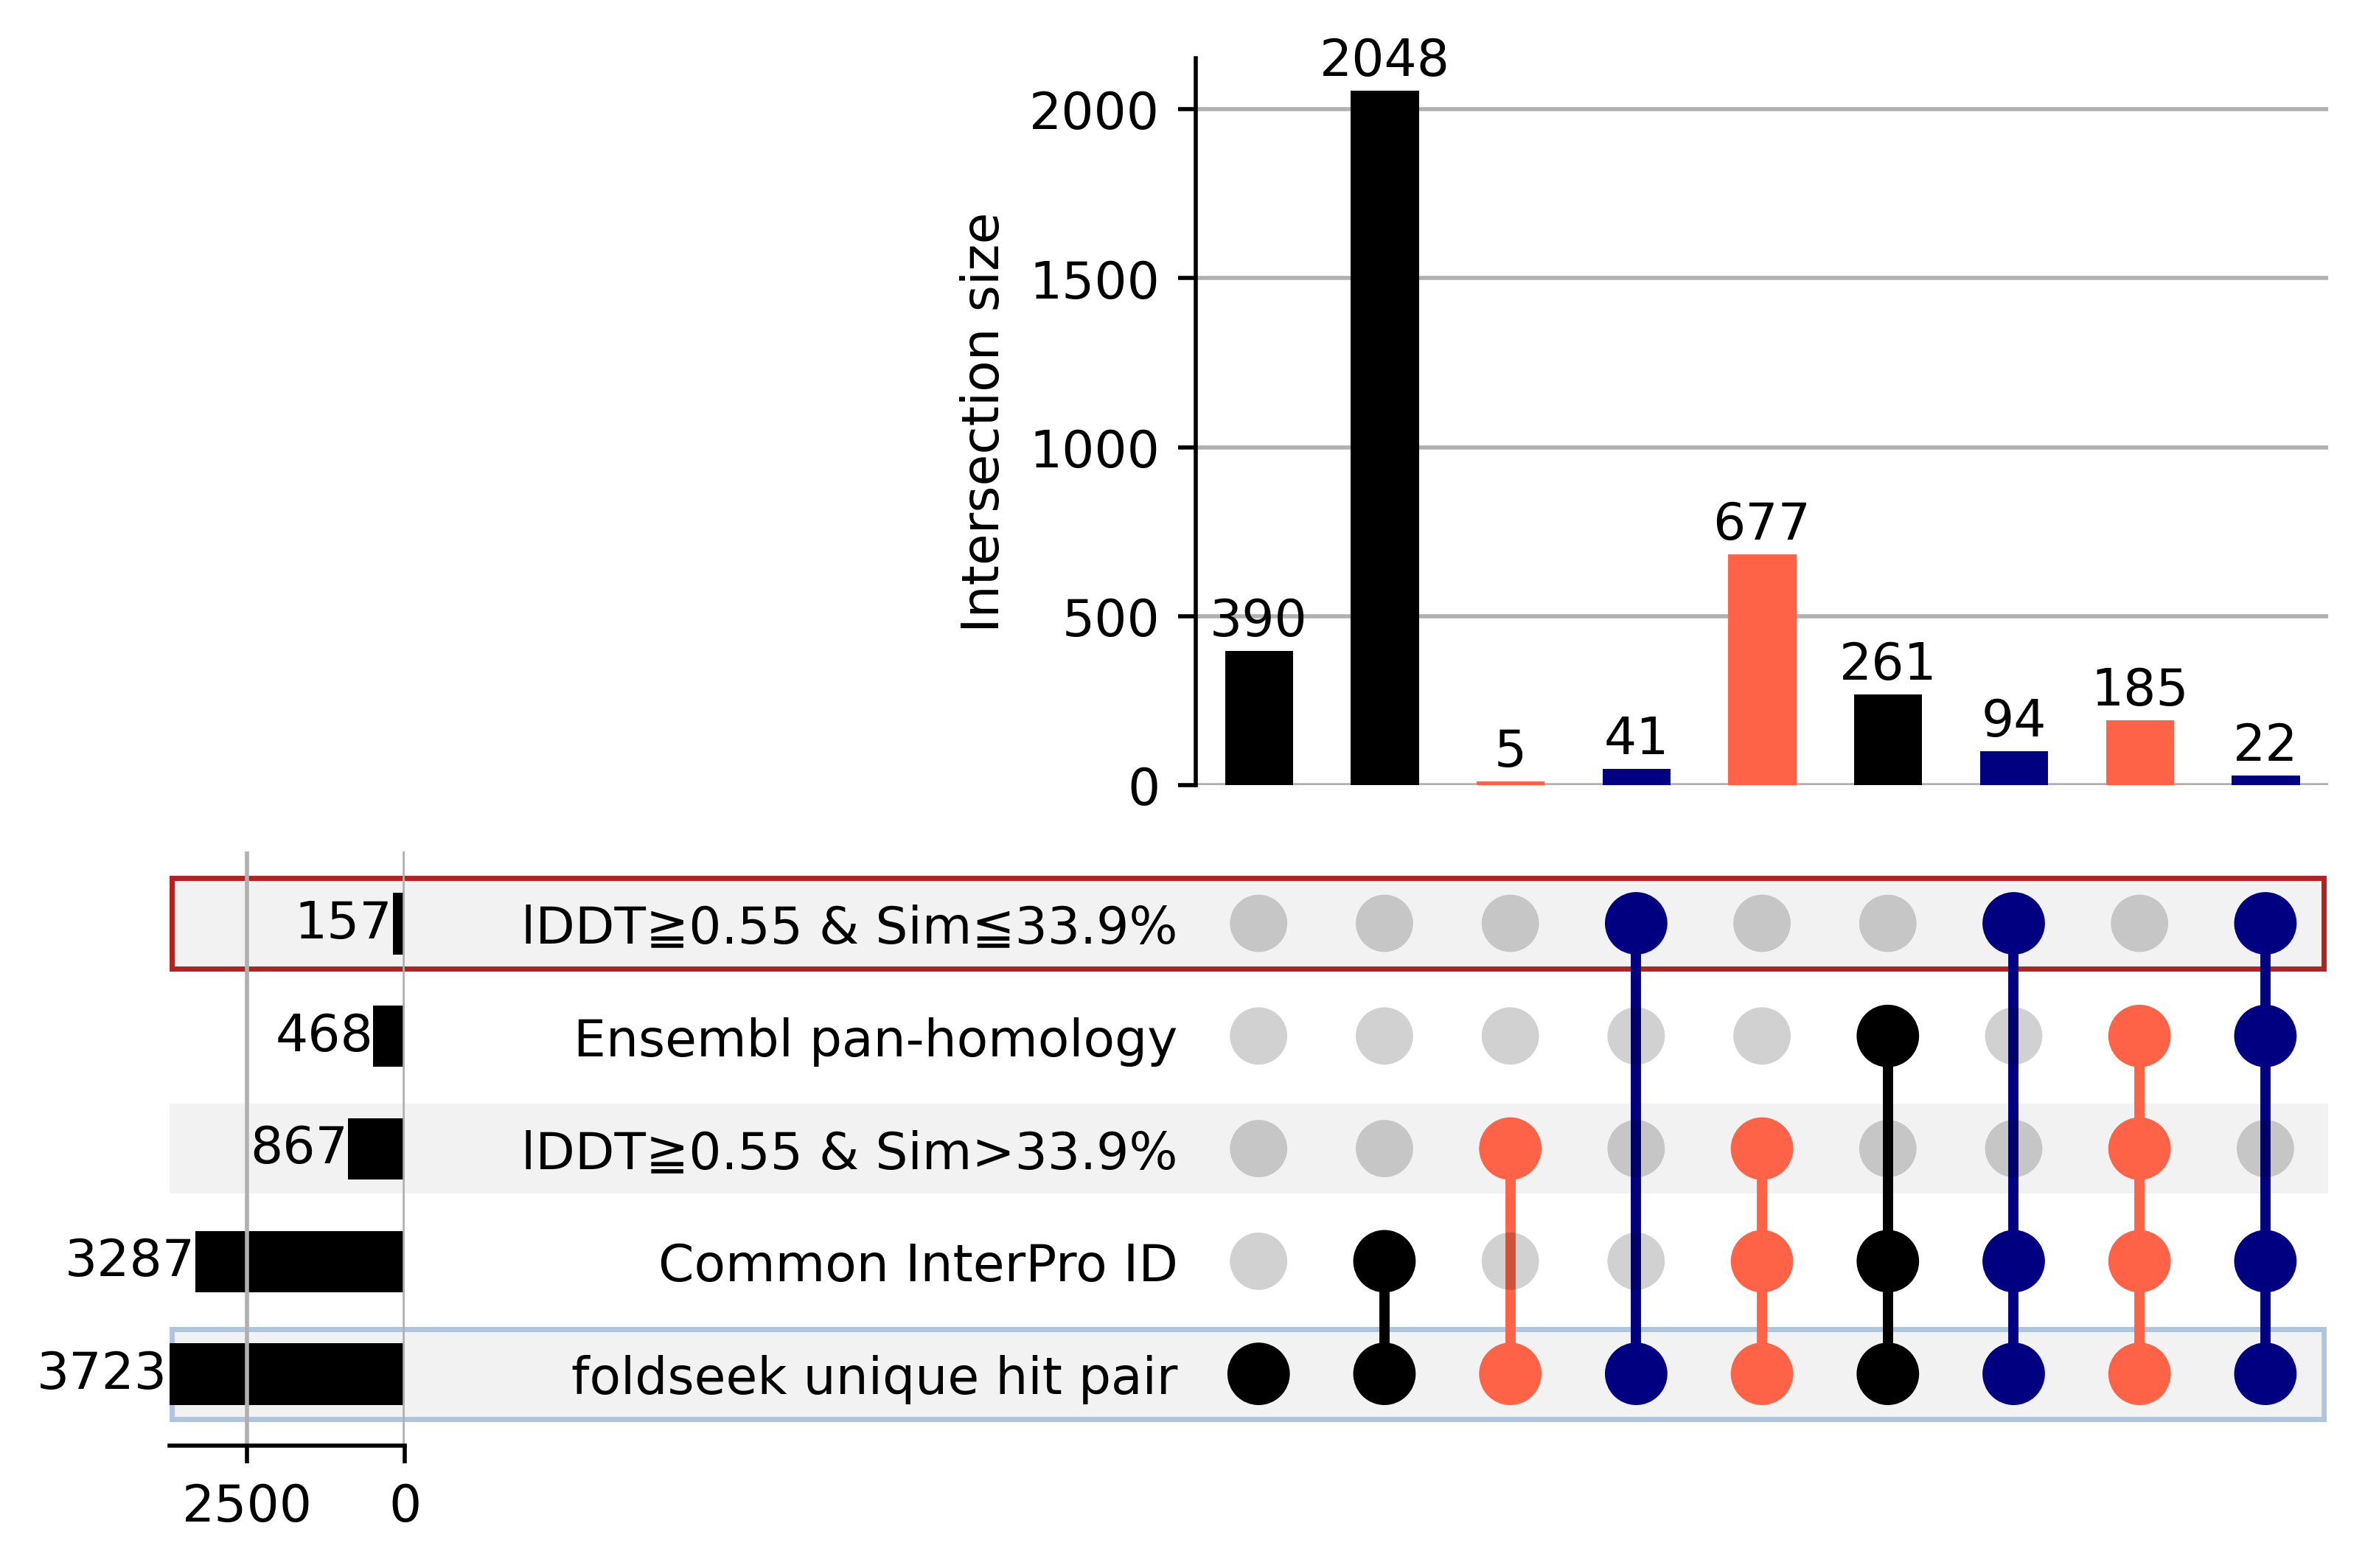

In [42]:
upset_plot = UpSet(
    upset_data_prototype,
    orientation='horizontal',
    show_counts="{:d}",
    subset_size='count',
    include_empty_subsets = False
)

upset_plot.style_subsets(
    present=[f"lDDT≧{median_y} & Sim>{third_quartile}%"], 
    facecolor="tomato"
)

upset_plot.style_subsets(
    present=[f"lDDT≧{median_y} & Sim≦{third_quartile}%"], 
    facecolor="navy"
)

upset_plot.style_categories(
    "foldseek unique hit pair",
    shading_edgecolor="lightsteelblue",
)

upset_plot.style_categories(
    f"lDDT≧{median_y} & Sim≦{third_quartile}%",
    shading_edgecolor="firebrick",
)


fig = plt.figure(figsize=(14, 8), dpi=500)
upset_plot.plot(fig=fig)
plt.show()

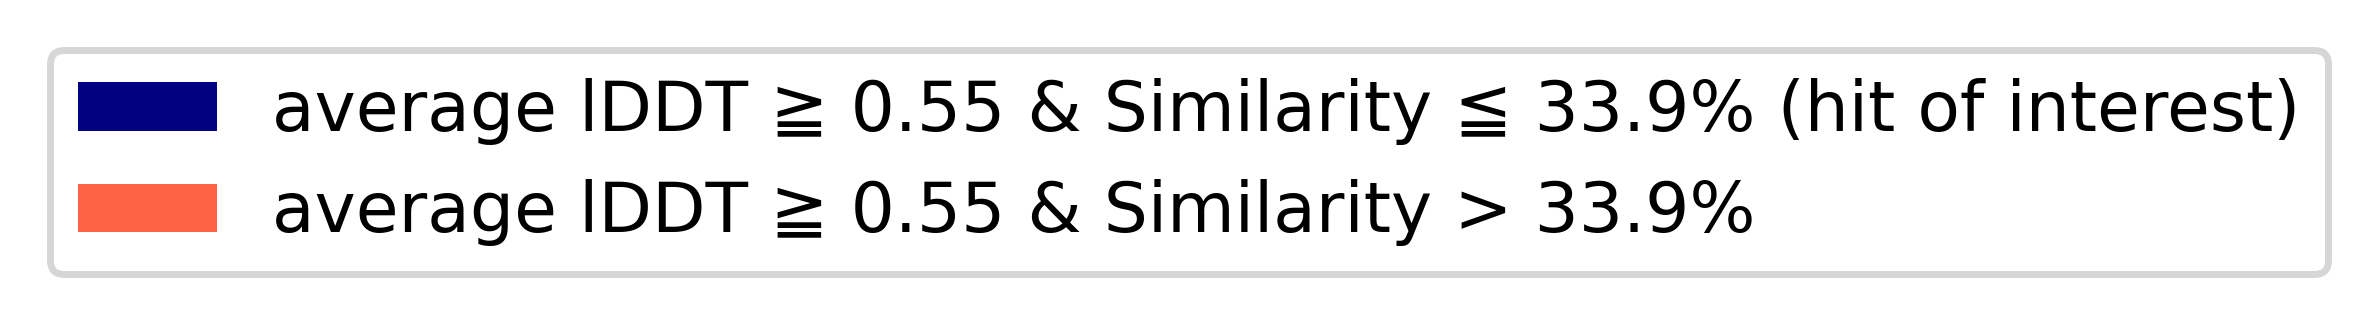

In [43]:
# Create legend independently
legend_elements = [
    Patch(facecolor="navy", label=f"average lDDT ≧ {median_y} & Similarity ≦ {third_quartile}% (hit of interest)"), # 条件4 (別の遺伝子であっても，同じfoldseek hit （例えばHSPB1とか）にヒットしているものも除外)
    Patch(facecolor="tomato", label=f"average lDDT ≧ {median_y} & Similarity > {third_quartile}%") # 条件1
]

fig_leg = plt.figure(figsize=(1.5, 0.5), dpi=500)
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(handles=legend_elements, loc='center')
ax_leg.axis('off') 
plt.show()

&nbsp;

&nbsp;

&nbsp;

&nbsp;

In [44]:
foldseek_contents = {
    "foldseek unique hit pair": condition3["hit label"].unique().sort().to_list(),
    f"lDDT≧{median_y} & Sim≦{third_quartile}%": condition3_filter_4["hit label"].unique().sort().to_list(),
    f"lDDT≧{median_y} & Sim>{third_quartile}%": condition3_filter_1["hit label"].unique().sort().to_list(),
    "Common InterPro ID": have_domain_info["hit label"].unique().sort().to_list(),
    "Ensembl pan-homology": ensembl_pan_homology_info["hit label"].unique().sort().to_list(),
    "HN-score sample contribution": hnscore_info["hit label"].unique().sort().to_list()
}

for key, value in foldseek_contents.items():
    print(f"{key}: {len(value)}")

upset_data = from_contents(foldseek_contents)
display(upset_data)

foldseek unique hit pair: 3723
lDDT≧0.55 & Sim≦33.9%: 157
lDDT≧0.55 & Sim>33.9%: 867
Common InterPro ID: 3287
Ensembl pan-homology: 468
HN-score sample contribution: 102


/usr/local/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


id
foldseek unique hit pair lDDT≧0.55 & Sim≦33.9% lDDT≧0.55 & Sim>33.9% Common InterPro ID Ensembl pan-homology HN-score sample contribution                    
True                     False                 False                 True               False                False                         foldseek-hit-10008
                                               True                  True               False                False                         foldseek-hit-10009
                                               False                 True               False                False                         foldseek-hit-10010
                                               True                  True               False                False                         foldseek-hit-10011
                                                                                                             False                         foldseek-hit-10013
...                                                                                                                                                       ...
                                               False                 True               True                 False                          foldseek-hit-9934
                                                                                        False                False                           foldseek-hit-998
                                                                                        True                 False                          foldseek-hit-9986
                                               True                  True               False                False                          foldseek-hit-9995
                                               False                 True               False                False                          foldseek-hit-9998

[3723 rows x 1 columns]

/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

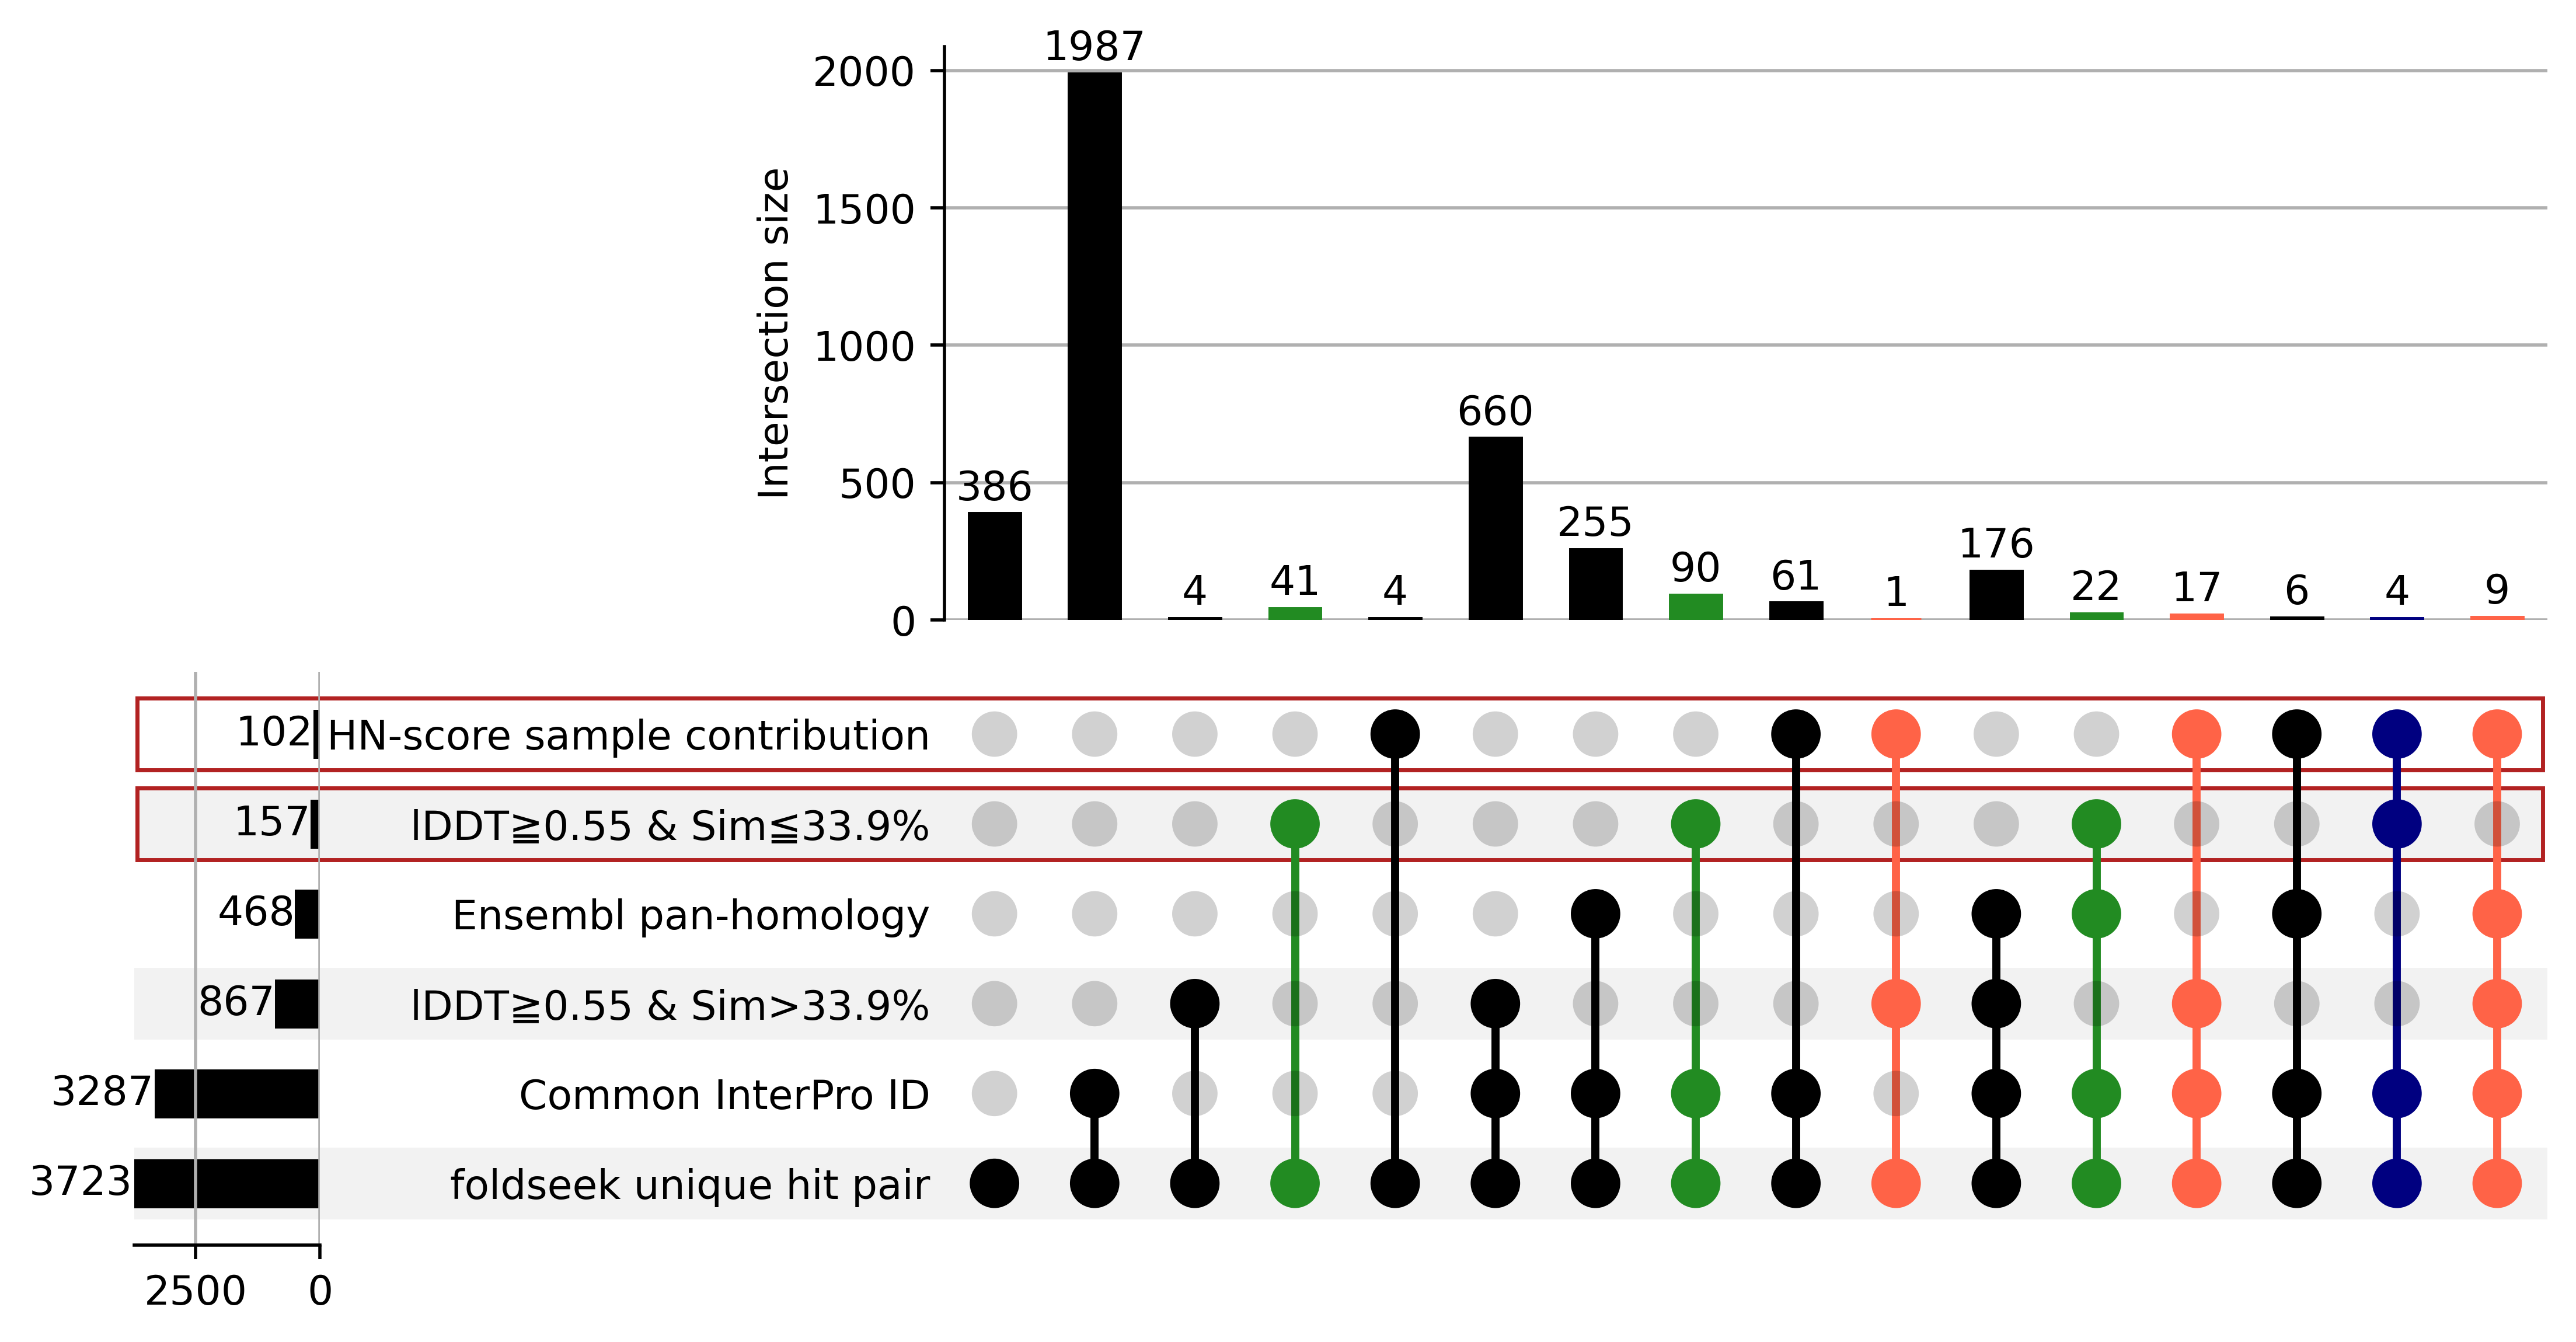

In [45]:
upset_plot = UpSet(
    upset_data,
    orientation='horizontal',
    show_counts="{:d}",
    subset_size='count',
    include_empty_subsets = False
)

upset_plot.style_subsets(
    present=[f"lDDT≧{median_y} & Sim≦{third_quartile}%", "HN-score sample contribution"], 
    facecolor="navy"
)

upset_plot.style_subsets(
    present=[f"lDDT≧{median_y} & Sim>{third_quartile}%", "HN-score sample contribution"], 
    facecolor="tomato"
)

upset_plot.style_subsets(
    present=[f"lDDT≧{median_y} & Sim≦{third_quartile}%"], 
    absent=["HN-score sample contribution"],
    facecolor="forestgreen"
)

upset_plot.style_categories(
    "foldseek hit",
    shading_edgecolor="lightsteelblue",
)

upset_plot.style_categories(
    f"lDDT≧{median_y} & Sim≦{third_quartile}%",
    shading_edgecolor="firebrick",
)

upset_plot.style_categories(
    "HN-score sample contribution",
    shading_edgecolor="firebrick",
)

fig = plt.figure(figsize=(14, 8), dpi=500)
upset_plot.plot(fig=fig)
plt.show()

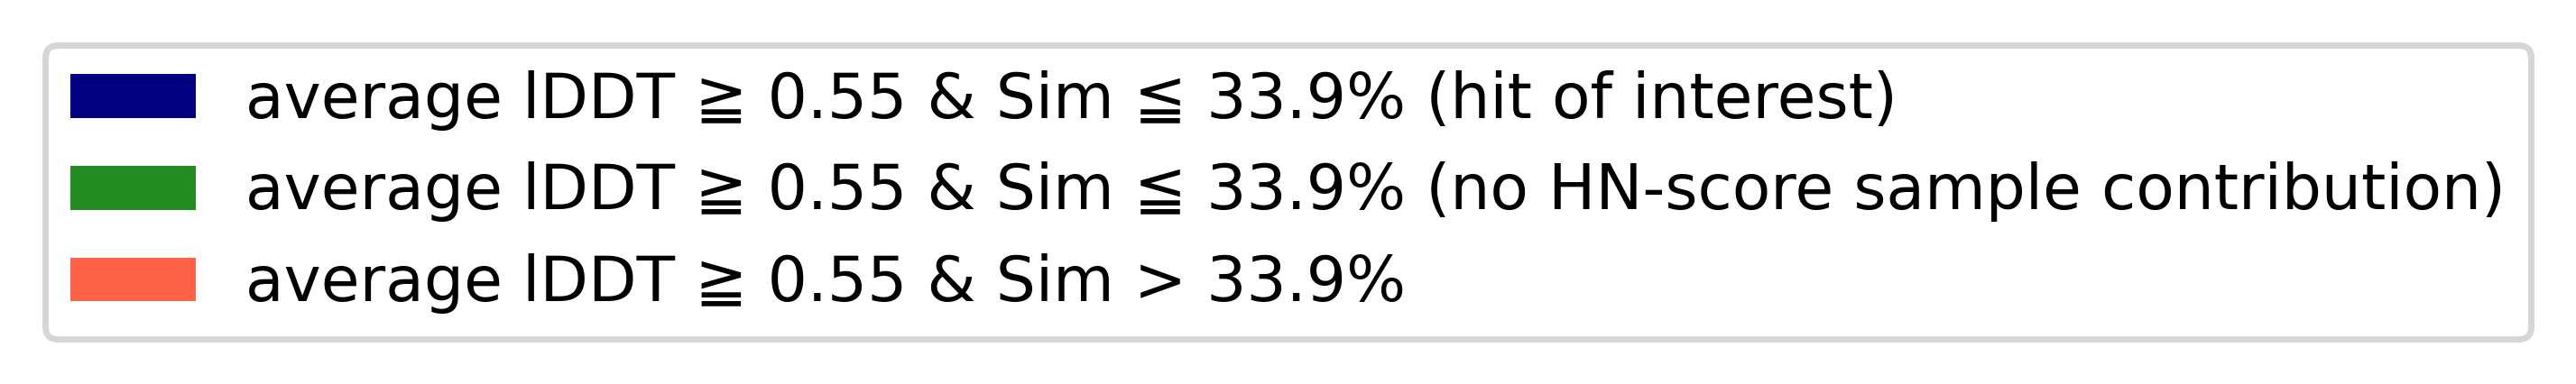

In [46]:
# Create legend independently
legend_elements = [
    Patch(facecolor="navy", label=f"average lDDT ≧ {median_y} & Sim ≦ {third_quartile}% (hit of interest)"),
    Patch(facecolor='forestgreen', label=f"average lDDT ≧ {median_y} & Sim ≦ {third_quartile}% (no HN-score sample contribution)"),
    Patch(facecolor="tomato", label=f"average lDDT ≧ {median_y} & Sim > {third_quartile}%")
]

fig_leg = plt.figure(figsize=(1.5, 0.5), dpi=500)
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(handles=legend_elements, loc='center')
ax_leg.axis('off') 
plt.show()
# fig_leg.savefig('legend.png', bbox_inches='tight')

&nbsp;

&nbsp;

## Genes of interest

In [47]:
genes_of_interest_hnscore = hnscore_info.filter(
    pl.col("hit label").is_in(condition3_filter_4["hit label"])
    # (pl.col("hit label").is_in(have_domain_info["hit label"])) # Add condition for common InterPro ID
)

print(genes_of_interest_hnscore.select("hit label").n_unique())
pl.Config.set_tbl_rows(40)
display(genes_of_interest_hnscore)

4


From,UniProt Accession,foldseek hit,hit label,hgnc_symbol_id,ensembl_gene_id,ensembl_protein_id,GENEID_mouse,HN5(all),HN5(all)_human,HN5(all)_mouse,positive_samples_count,positive_samples_count_human,positive_samples_count_mouse,negative_samples_count,negative_samples_count_human,negative_samples_count_mouse,total_samples,total_samples_human,total_samples_mouse,positive_samples_count_all,negative_samples_count_all
str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Os01g0279400""","""Q8H6D6""","""O15403""","""foldseek-hit-562""","""SLC16A6""","""ENSG00000108932""","""ENSP00000319991""","""Slc16a6""",-57,-7,-7,1,4,2,9,6,4,15,30,30,7,19
"""Os01g0279400""","""Q8H6D6""","""O15403""","""foldseek-hit-562""","""SLC16A6""","""ENSG00000108932""","""ENSP00000462985""","""Slc16a6""",-57,-7,-7,1,4,2,9,6,4,15,30,30,7,19
"""Os05g0475700""","""A0A0P0WNL1""","""O15403""","""foldseek-hit-6347""","""SLC16A6""","""ENSG00000108932""","""ENSP00000319991""","""Slc16a6""",-58,-7,-7,1,4,2,8,6,4,15,30,30,7,18
"""Os05g0475700""","""A0A0P0WNL1""","""O15403""","""foldseek-hit-6347""","""SLC16A6""","""ENSG00000108932""","""ENSP00000462985""","""Slc16a6""",-58,-7,-7,1,4,2,8,6,4,15,30,30,7,18
"""Os05g0475700""","""Q0DHC7""","""Q7RTY1""","""foldseek-hit-6409""","""SLC16A9""","""ENSG00000165449""","""ENSP00000378756""","""Slc16a9""",-58,-2,-10,1,3,1,8,5,4,15,30,30,5,17
"""Os05g0475700""","""Q0DHC7""","""Q7RTY1""","""foldseek-hit-6409""","""SLC16A9""","""ENSG00000165449""","""ENSP00000378757""","""Slc16a9""",-58,-2,-10,1,3,1,8,5,4,15,30,30,5,17
"""Os12g0555200""","""Q0IMQ1""","""B8ZZV9""","""foldseek-hit-13375""","""COQ10B""","""ENSG00000115520""","""ENSP00000387223""","""Coq10b""",-75,1,1,1,4,3,7,5,4,15,30,30,8,16


In [48]:
genes_of_interest_hnscore_filter = genes_of_interest_hnscore.select(
    "hit label",
    "From",
    "UniProt Accession",
    "foldseek hit",
    "hgnc_symbol_id"
).unique().sort(
    by=["foldseek hit"],
    descending=False
)

genes_of_interest_hnscore_filter.write_csv(
    "../out/rice_up/genes_of_interest_hnscore_filter.tsv", # or genes_of_interest_hnscore_filter_common_interpro.tsv
    separator="\t"
)

print(genes_of_interest_hnscore_filter.select("hit label").n_unique())
display(genes_of_interest_hnscore_filter)

4


hit label,From,UniProt Accession,foldseek hit,hgnc_symbol_id
str,str,str,str,str
"""foldseek-hit-13375""","""Os12g0555200""","""Q0IMQ1""","""B8ZZV9""","""COQ10B"""
"""foldseek-hit-6347""","""Os05g0475700""","""A0A0P0WNL1""","""O15403""","""SLC16A6"""
"""foldseek-hit-562""","""Os01g0279400""","""Q8H6D6""","""O15403""","""SLC16A6"""
"""foldseek-hit-6409""","""Os05g0475700""","""Q0DHC7""","""Q7RTY1""","""SLC16A9"""


In [49]:
genes_of_interest_hnscore_2 = hnscore_info.filter(
    pl.col("hit label").is_in(condition3_filter_1["hit label"])
)

print(genes_of_interest_hnscore_2.select("hit label").n_unique())
display(genes_of_interest_hnscore_2)

27


From,UniProt Accession,foldseek hit,hit label,hgnc_symbol_id,ensembl_gene_id,ensembl_protein_id,GENEID_mouse,HN5(all),HN5(all)_human,HN5(all)_mouse,positive_samples_count,positive_samples_count_human,positive_samples_count_mouse,negative_samples_count,negative_samples_count_human,negative_samples_count_mouse,total_samples,total_samples_human,total_samples_mouse,positive_samples_count_all,negative_samples_count_all
str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Os01g0627400""","""A0A0P0V5H0""","""P24462""","""foldseek-hit-1536""","""CYP3A7""","""ENSG00000160870""","""ENSP00000337450""","""Cyp3a13""",-51,-7,4,3,1,4,6,7,2,15,30,30,8,15
"""Os01g0627400""","""A0A0P0V5H0""","""P24462""","""foldseek-hit-1536""","""CYP3A7""","""ENSG00000160870""","""ENSP00000337450""","""Cyp3a59""",-51,-7,1,3,1,1,6,7,0,15,30,30,5,13
"""Os01g0627400""","""A0A0P0V5H0""","""P24462""","""foldseek-hit-1536""","""CYP3A7""","""ENSG00000160870""","""ENSP00000337450""","""Cyp3a25""",-51,-7,-4,3,1,1,6,7,3,15,30,30,5,16
"""Os01g0854800""","""Q5N7U6""","""Q9HCS2""","""foldseek-hit-2443""","""CYP4F12""","""ENSG00000186204""","""ENSP00000448998""","""Cyp4f14""",-45,-1,2,0,5,4,6,5,2,15,30,30,9,13
"""Os01g0854800""","""Q5N7U6""","""Q9HCS2""","""foldseek-hit-2443""","""CYP4F12""","""ENSG00000186204""","""ENSP00000430849""","""Cyp4f14""",-45,-1,2,0,5,4,6,5,2,15,30,30,9,13
"""Os01g0854800""","""Q5N7U6""","""Q9HCS2""","""foldseek-hit-2443""","""CYP4F12""","""ENSG00000186204""","""ENSP00000449703""","""Cyp4f14""",-45,-1,2,0,5,4,6,5,2,15,30,30,9,13
"""Os01g0854800""","""Q5N7U6""","""Q9HCS2""","""foldseek-hit-2443""","""CYP4F12""","""ENSG00000186204""","""ENSP00000321821""","""Cyp4f14""",-45,-1,2,0,5,4,6,5,2,15,30,30,9,13
"""Os02g0684500""","""Q7XUC9""","""P62805""","""foldseek-hit-3578""","""H4C14""","""ENSG00000270882""","""ENSP00000478786""","""H4c2""",-54,9,8,3,7,11,7,5,5,15,30,30,21,17
"""Os02g0684500""","""Q7XUC9""","""P62805""","""foldseek-hit-3578""","""H4C14""","""ENSG00000270882""","""ENSP00000481343""","""H4c2""",-54,9,8,3,7,11,7,5,5,15,30,30,21,17


In [50]:
genes_of_interest_hnscore_2_filter = genes_of_interest_hnscore_2.select(
    "hit label",
    "From",
    "UniProt Accession",
    "foldseek hit",
    "hgnc_symbol_id"
).unique().sort(
    by=["From"],
    descending=False
)

genes_of_interest_hnscore_2_filter.write_csv(
    "../out/rice_up/genes_of_interest_hnscore_2_filter.tsv",
    separator="\t"
)

display(genes_of_interest_hnscore_2_filter)

hit label,From,UniProt Accession,foldseek hit,hgnc_symbol_id
str,str,str,str,str
"""foldseek-hit-1536""","""Os01g0627400""","""A0A0P0V5H0""","""P24462""","""CYP3A7"""
"""foldseek-hit-2443""","""Os01g0854800""","""Q5N7U6""","""Q9HCS2""","""CYP4F12"""
"""foldseek-hit-3578""","""Os02g0684500""","""Q7XUC9""","""P62805""","""H4C15"""
"""foldseek-hit-3578""","""Os02g0684500""","""Q7XUC9""","""P62805""","""H4C6"""
"""foldseek-hit-3578""","""Os02g0684500""","""Q7XUC9""","""P62805""","""H4C1"""
"""foldseek-hit-3578""","""Os02g0684500""","""Q7XUC9""","""P62805""","""H4C13"""
"""foldseek-hit-3578""","""Os02g0684500""","""Q7XUC9""","""P62805""","""H4C14"""
"""foldseek-hit-3654""","""Os03g0162200""","""Q8H7Y8""","""Q8IUE6""","""H2AC21"""
"""foldseek-hit-3649""","""Os03g0162200""","""Q8H7Y8""","""Q16777""","""H2AC20"""
